In [3]:
from __future__ import print_function, division

import os
import operator
import functools
import time
import glob
import tables as tb
import pandas as pd
print("Running on ", time.asctime())

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import invisible_cities.database.load_db as DB
import invisible_cities.core.system_of_units_c as SystemOfUnits
import invisible_cities.reco.pmaps_functions as pmapf
import invisible_cities.core.fit_functions as fitf

DataPMT = DB.DataPMT()
DataSiPM = DB.DataSiPM()
units = SystemOfUnits.SystemOfUnits()
pi = np.pi


Running on  Tue May  9 19:32:25 2017


#### General plotting options

In [4]:
plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

outputfolder = "plots/Na_3614/3_5_17"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)
print(outputfolder)

plots/Na_3614/3_5_17


#### Usefull functions

In [28]:
def width(times, to_mus=False):
    """
    Compute peak width.
    """
    w = (np.max(times) - np.min(times)) if np.any(times) else 0.
    return w * units.ns/units.mus if to_mus else w


def timefunc(f):
    """
    Decorator for function timing.
    """
    def time_f(*args, **kwargs):
        t0 = time.time()
        output = f(*args, **kwargs)
        print("Time spent in {}: {} s".format(f.__name__,
                                              time.time() - t0))
        return output
    return time_f


def integrate_charge(d):
    """
    Integrate charge from a SiPM dictionary.
    """
    newd = dict((key, np.sum(value)) for key, value in d.items())
    return map(np.array, list(zip(*newd.items())))


def flat(nested_list):
    while hasattr(nested_list[0], "__iter__"):
        nested_list = [item for inner_list in nested_list for item in inner_list]
    return np.array(nested_list)


def labels(xlabel, ylabel):
    """
    Set x and y labels.
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def hist(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist(*args, **kwargs)

    
def hist2d(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist2d(*args, **kwargs)

    
def pdf(data, *args, **kwargs):
    """
    Create a normalized histogram with appropiate range.
    """
    data = np.array(data)
    h = hist(data, *args, **kwargs, weights=np.ones_like(data)/len(data))
    plt.yscale("log")
    plt.ylim(1e-4, 1.)
    return h
    
def scatter(*args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    return plt.scatter(*args, **kwargs)


def save_to_folder(outputfolder, name):
    """
    Set title and save plot in folder.
    """
    plt.title(name)
    plt.savefig("{}/{}.png".format(outputfolder, name), dpi=100)



def get_centers(xbins):
    # xbins should be shifted, as it contains the lower bounds
    # and we want bin centers
    return xbins[:-1] + np.diff(xbins) * 0.5


def profile_and_scatter(x, y, z, nbin, xrange, yrange, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    x, y, z, ze = fitf.profileXY(x, y, z, *nbin, xrange, yrange)
    x_ = np.repeat(x, x.size)
    y_ = np.tile  (y, y.size)
    z_ = z.flatten()
    return (x, y, z, ze), plt.hist2d(x_, y_,nbin, (xrange, yrange), weights=z_), plt.colorbar()

save = functools.partial(save_to_folder, outputfolder)

### Input data

In [9]:
# Comment out this line if your data is in $IC_DATA
os.environ["IC_DATA"] = "/home/brais/Documents/Next/Na/data/3614/"

pattern = "$IC_DATA/*.root.h5"
ifiles  = glob.glob(os.path.expandvars(pattern))
print("# files:", len(ifiles))

# files: 1


### Reading data

In [10]:
def load_dst(filename, group, node):
    with tb.open_file(filename) as h5in:
        table = getattr(getattr(h5in.root, group), node).read()
        return pd.DataFrame.from_records(table)

In [11]:
data_read = load_dst(ifiles[0], "DST", "Events")

In [12]:
data_read

event          time  peak  nS2    S1w        S1h         S1e  \
0            1  1.491674e+09     0    1  275.0  49.620018  287.162550   
1            2  1.491674e+09     0    1  200.0  24.205078  129.749825   
2            4  1.491674e+09     0    1  225.0  30.098822  160.997304   
3            5  1.491674e+09     0    2  225.0  54.494896  286.139376   
4            5  1.491674e+09     1    2  225.0  54.494896  286.139376   
5            8  1.491674e+09     0    1  325.0  31.736614  165.305724   
6            9  1.491674e+09     0    1  225.0  26.748526  159.692408   
7           10  1.491674e+09     0    1  250.0  52.593689  285.323524   
8           11  1.491674e+09     0    1  250.0  13.720692   90.543010   
9           12  1.491674e+09     0    1  175.0  13.480074   72.238658   
10          13  1.491674e+09     0    1  175.0  22.057390  108.670282   
11          14  1.491674e+09     0    1  150.0  11.884805   55.847104   
12          15  1.491674e+09     0    1  200.0  23.228331  125.666456   
13          16  1.491674e+09     0    1  250.0  36.039127  187.543282   
14          17  1.491674e+09     0    1  275.0  43.597187  259.031179   
15          18  1.491674e+09     0    1  200.0  26.175219  133.905174   
16          19  1.491674e+09     0    1  225.0  32.297810  169.219266   
17          20  1.491674e+09     0    2  225.0  37.718376  217.355925   
18          20  1.491674e+09     1    2  225.0  37.718376  217.355925   
19          22  1.491674e+09     0    1  125.0  11.454111   49.972588   
20          23  1.491674e+09     0    1  250.0  54.874886  299.711311   
21          24  1.491674e+09     0    1  250.0  25.593683  153.015466   
22          25  1.491674e+09     0    1  150.0   9.022266   44.049409   
23          26  1.491674e+09     0    1  150.0  14.157608   65.870162   
24          27  1.491674e+09     0    1  175.0  13.342910   72.002379   
25          29  1.491674e+09     0    1  300.0  34.331474  207.085409   
26          30  1.491674e+09     0    1  275.0  36.725208  206.326743   
27          31  1.491674e+09     0    1  250.0  22.075649  124.195831   
28          32  1.491674e+09     0    1  250.0  22.347191  125.900764   
29          33  1.491674e+09     0    1  175.0  26.986101  129.249688   
...        ...           ...   ...  ...    ...        ...         ...   
363055  163971  1.491755e+09     0    1  175.0  16.228619   82.860441   
363056  163972  1.491755e+09     0    1  175.0  20.128096  104.106472   
363057  163973  1.491755e+09     0    1  150.0  14.492738   66.143864   
363058  163974  1.491755e+09     0    2  300.0  42.964642  235.939162   
363059  163974  1.491755e+09     1    2  300.0  42.964642  235.939162   
363060  163975  1.491755e+09     0    1  125.0  11.089585   47.662466   
363061  163976  1.491755e+09     0    1  125.0   8.365206   38.268194   
363062  163977  1.491755e+09     0    1  250.0  42.913876  234.277174   
363063  163978  1.491755e+09     0    1  225.0  24.350698  134.575125   
363064  163980  1.491755e+09     0    1  200.0  20.097082  106.884434   
363065  163981  1.491755e+09     0    2  200.0  27.182816  141.199812   
363066  163981  1.491755e+09     1    2  200.0  27.182816  141.199812   
363067  163982  1.491755e+09     0    1  125.0   9.561171   41.416276   
363068  163985  1.491755e+09     0    1  225.0  25.853392  130.070743   
363069  163986  1.491755e+09     0    1  150.0   9.388821   49.053054   
363070  163987  1.491755e+09     0    1  225.0  12.621846   74.369083   
363071  163988  1.491755e+09     0    1  250.0  34.890835  184.700860   
363072  163989  1.491755e+09     0    1  150.0   9.443189   48.372062   
363073  163990  1.491755e+09     0    1  225.0  30.166779  164.597299   
363074  163991  1.491755e+09     0    1  200.0  14.417026   82.337029   
363075  163992  1.491755e+09     0    1  175.0  18.819590   89.406840   
363076  163993  1.491755e+09     0    1  200.0  26.676138  142.499232   
363077  163994  1.491755e+09     0    1  325.0  37.559299  226.4695


### Filtering data

In [13]:
from copy import deepcopy
from functools import reduce

def Filter(data):
    filtered_XR = deepcopy(data)
    filtered_noXR = deepcopy(data)
    
    min_S1w = 250.
    max_S1w = 400.
    min_S1h = 10.
    max_S1h = 100.
    
    min_S2e = 1000.
    max_S2e = 12000.
    
    print('Inicial: ',len(filtered_XR), len(filtered_noXR))

    filtered_XR = filtered_XR[filtered_XR.nS2>1]
    print('nS2 > 1: ', len(filtered_XR))
    
    filtered_XR = filtered_XR[filtered_XR.S2e>min_S2e]
    filtered_XR = filtered_XR[filtered_XR.S2e<max_S2e]
    
    
    print('S2 XR Energy: ', len(filtered_XR))
    
    filtered_XR = filtered_XR[filtered_XR.Nsipm>0]
    
    print('Nsimp > 0: ', len(filtered_XR))
    

    
    
    #filtered_noXR = filtered_noXR[filtered_noXR.S2e<min_S2e]
    filtered_noXR = filtered_noXR[filtered_noXR.S2e>max_S2e]
    
    print('no XR: ', len(filtered_noXR))
    
    return filtered_XR, filtered_noXR


In [14]:
filt_XR, filt_noXR = Filter(data_read)
full = data_read[:]

Inicial:  363085 363085
nS2 > 1:  89778
S2 XR Energy:  27890
Nsimp > 0:  27890
no XR:  335195


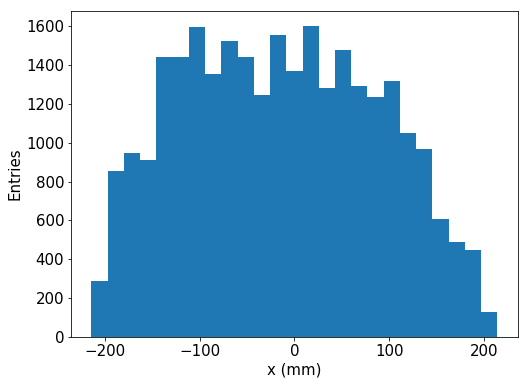

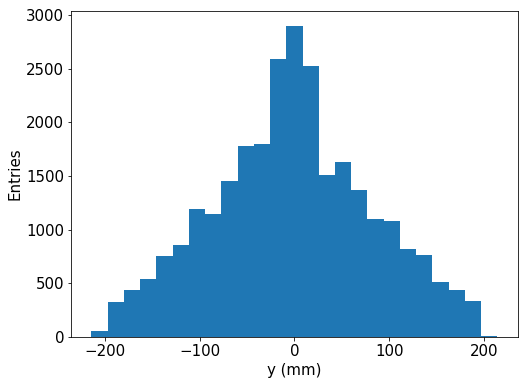

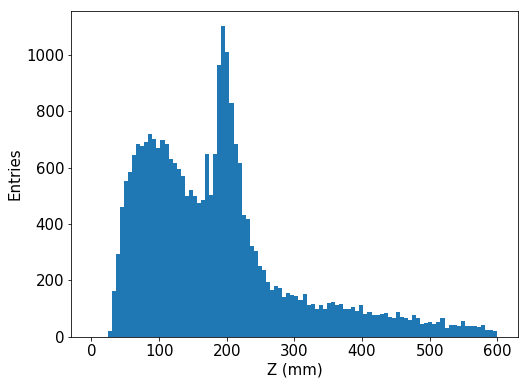

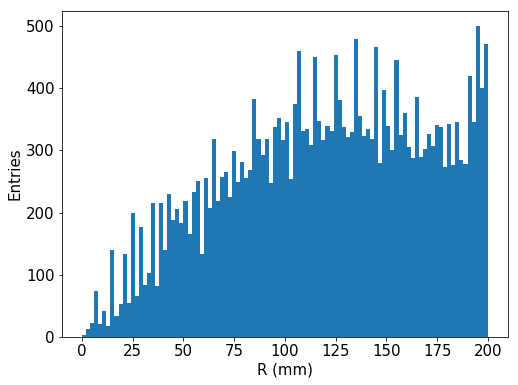

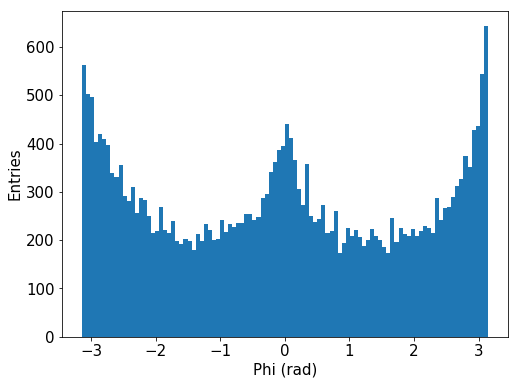

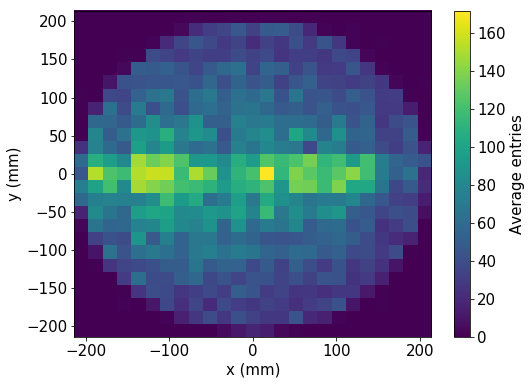

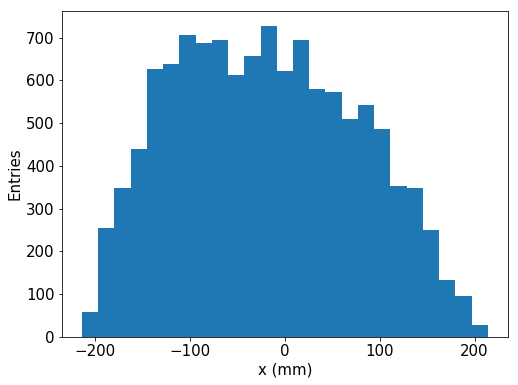

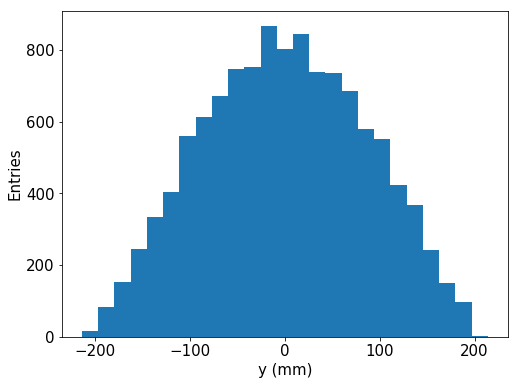

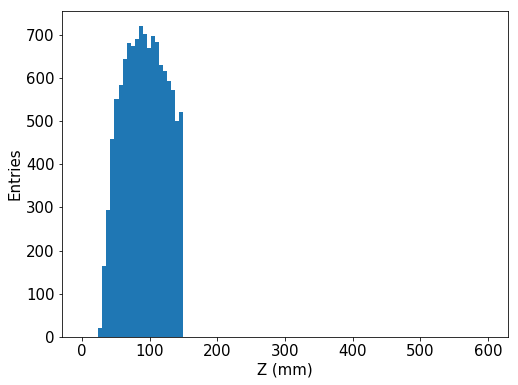

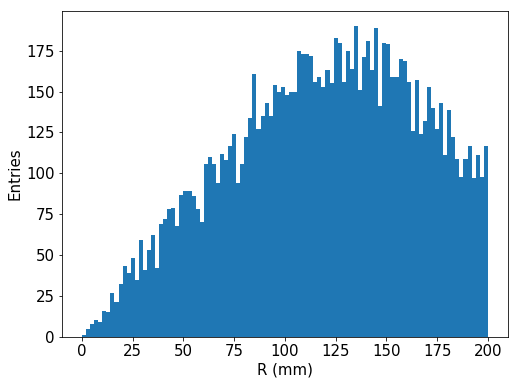

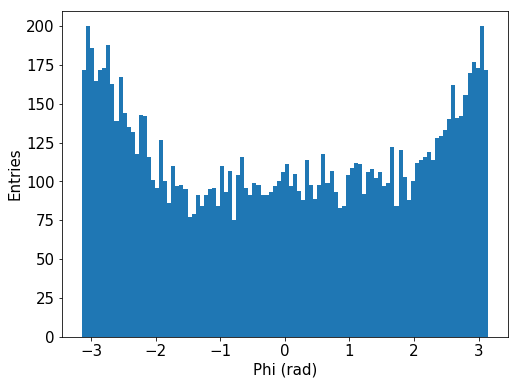

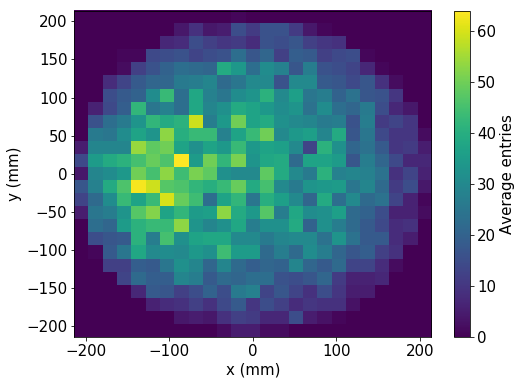

In [15]:
data = filt_XR[filt_XR.Z<150]


hist(filt_XR.X,25,[-214,214]);
labels("x (mm)", "Entries")
#save("XR X Position")

hist(filt_XR.Y,25,[-214,214]);
labels("y (mm)", "Entries")
#save("XR Y Position")

hist(filt_XR.Z,100,[0,600]);
labels("Z (mm)", "Entries")
#save("XR Z Position")

hist(filt_XR.R,100,[0,200]);
labels("R (mm)", "Entries")
#save("XR R Position")

hist(filt_XR.Phi,100,[-pi,pi]);
labels("Phi (rad)", "Entries")
#save("XR Phi Position")

hist2d(filt_XR.X,filt_XR.Y,[25,25],[[-214,214],[-214,214]])
plt.colorbar().set_label("Average entries")
labels("x (mm)", "y (mm)")
#save("XR XY Position")

hist(data.X,25,[-214,214]);
labels("x (mm)", "Entries")
#save("XR X Position (Z<150)")

hist(data.Y,25,[-214,214]);
labels("y (mm)", "Entries")
#save("XR Y Position (Z<150)")

hist(data.Z,100,[0,600]);
labels("Z (mm)", "Entries")
#save("XR Z Position (Z<150)")

hist(data.R,100,[0,200]);
labels("R (mm)", "Entries")
#save("XR R Position (Z<150)")

hist(data.Phi,100,[-pi,pi]);
labels("Phi (rad)", "Entries")
#save("XR Phi Position (Z<150)")

hist2d(data.X,data.Y,[25,25],[[-214,214],[-214,214]])
plt.colorbar().set_label("Average entries")
labels("x (mm)", "y (mm)")
#save("XR XY Position (Z<150)")

### S1 and S2 propierties

In [ ]:
hist(filt_XR.Nsipm,10,[0,10])
np.mean(filt_XR.Nsipm)

In [ ]:
hist(full.nS2,100);

In [ ]:
s1t = filt_XR.S1t/1e3

hist(s1t, 100)
labels("S1 time (mus)", "Entries")
save("S1time")

In [ ]:
s1w = filt_XR.S1w

################################
hist(s1w, 100)#, range=(0, 900))
labels("S1 width (ns)", "Entries")
save("S1width")

################################

scatter(filt_XR.Z, s1w)
#x, y, _ = fitf.profileX(filt_XR.Z, s1w, 50)
#plt.plot(x, y, profOpt)
#f = fitf.fit(fitf.polynom, x, y, (1., 1.))
#plt.plot(x, f.fn(x), fitOpt)
#plt.text(20, 20, "{:.3f} + {:.3f} x".format(*f.values))
labels("Drift time ($\mu$s)", "S1 width (ns)")

save("S1widthvsZ")

In [ ]:
s1h = filt_XR.S1h


################################
hist(s1h, 40)
#plt.semilogy()
labels("S1 height (pes)", "Entries")
save("S1height")

################################

hist2d(filt_XR.Z, s1h,[100,100])
#x, y, _ = fitf.profileX(data.Z[:,0], s1h, 100)
#plt.plot(x, y, profOpt)
#f = fitf.fit(fitf.polynom, x, y, (1., 0.8, 0.01))
#plt.plot(x, f.fn(x), fitOpt)
#plt.text(0, 6, "{:.3g} + {:.3g} x + {:.3g} x^2".format(*f.values))
labels("Drift time ($\mu$s)", "S1 height (pes)")
#plt.ylim(0, 100)
save("S1heightvsZ")


In [ ]:
s1h = filt_XR.S1h
s1w = filt_XR.S1w

scatter(s1h,s1w)
plt.yscale
#x, y, _ = fitf.profileX(s1h, s1w, 100)
#plt.plot(x, y, profOpt)
#f = fitf.fit(fitf.polynom, x, y, (1., 1e-2, 1e-4))
#plt.plot(x, f.fn(x), fitOpt)
#plt.text(0, 100, "{:.3g} + {:.3g} x + {:.3g} x^2".format(*f.values))
labels("S1 height (pes)", "S1 width (ns)")
#plt.xlim(0, 100)
save("S1withvsS1Height")

In [ ]:
s1e = filt_XR.S1e

################################
hist(s1e, 50, range=(0, 600))
labels("S1 integral (pes)", "Entries")
save("S1energy")

################################
pdf(s1e, 50, range=(0, 600))
labels("S1 integral (pes)", "Entries")
save("S1energy_log")

################################

hist2d(filt_XR.Z, s1e,[100,100],range=([[0,300],[0,200]]))
x, y, _ = fitf.profileX(filt_XR.Z, s1e, 100, xrange=[0,300],yrange=[0,200])
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S1 energy (pes)")

save("S1vsZ")


In [ ]:
################################
y, x, _ = hist(s1h/s1e, 50, range=(0, 0.5))
x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e5, 0.3, 0.01))
#plt.plot(x, f.fn(x), "r")
labels("Peak to area ratio (pes/pes)", "Entries")
save("S1peak2area")

In [ ]:
s2t =filt_XR.S2t/1e3

################################
hist(s2t, 100)#, range=(0, 10e2))
labels("S2 time (mus)", "Entries")
save("S2time_ok")

In [ ]:
data = full[(full.S1e>100)&(full.S1e<150)&(full.S2e>50e3)&(full.S2e<100e3)&(full.Z<200)&(full.Z>150)]


################################
hist(data.S2w, 30, range=(0, 100))
labels("S2 width (mus)", "Entries")
save("S2width")

################################
hist2d(data.Z, data.S2w,[100,100],range=[[150,200],[0,40]]);
hist2d(data.S2q, data.S2w,[100,100]);
hist2d(data.S2q, data.S2h,[100,100]);
hist2d(data.S2e, data.S2h,[100,100]);
hist(data.S2h/data.S2e,100)
#x, y, _ = fitf.profileX(data.Z, s2w, 100)
#plt.plot(x, y, profOpt)
#f = fitf.fit(fitf.power, x, y, (1., 0.8))
#plt.plot(x, f.fn(x), fitOpt)
#plt.text(0, 20, "{:.3f} $\cdot$ x^{:.2f}".format(*f.values))
#labels("Drift time ($\mu$s)", "S2 width ($\mu$s)")
#plt.ylim(0, 30)
#save("S2widthvsZ")

################

hist2d(data.S2q,data.S2e,[100,100]);
hist2d(data.S2q,data.S2e,[100,100]);

In [ ]:
s2h = filt_XR.S2h
s2w = filt_XR.S2h
################################
hist(s2h, 100)#, range=(0, 15e3))
labels("S2 height (pes)", "Entries")
save("S2height")

################################
scatter(filt_XR.Z, s2h)
x, y, _ = fitf.profileX(filt_XR.Z, s2h, 100)
plt.plot(x, y, profOpt)
fun = lambda x, *args: fitf.expo(x,*args[:2])/fitf.power(x, *args[2:])
f = fitf.fit(fun, x, y, (1., -2e4, 0.1, -0.8))
plt.plot(x, f.fn(x), fitOpt)
plt.text(1e2, 4e3, "{:.3f} exp(x/{:.3g}) / "
                   "({:.3g} $\cdot$ x^{:.2f})".format(*f.values))
labels("Drift time ($\mu$s)", "S2 height (pes)")
plt.ylim(0, 3e4)
save("S2heightvsZ")

################################
scatter(s2w, s2h)
#x, y, _ = fitf.profileX(s2w, s2h, 50)
#plt.plot(x, y, profOpt)
#f = fitf.fit(fitf.power, x, y, (1., -1.0))
#plt.plot(x, f.fn(x), fitOpt)
#plt.text(10, 4e3, "{:.3f} $\cdot$ x^{:.2f}".format(*f.values))
labels("S2 width ($\mu$s)", "S2 height (pes)")
#plt.ylim(0, 3e4)
#plt.xlim(0,100)
save("S2heightvsS2width")

In [89]:
from matplotlib.colors import LogNorm

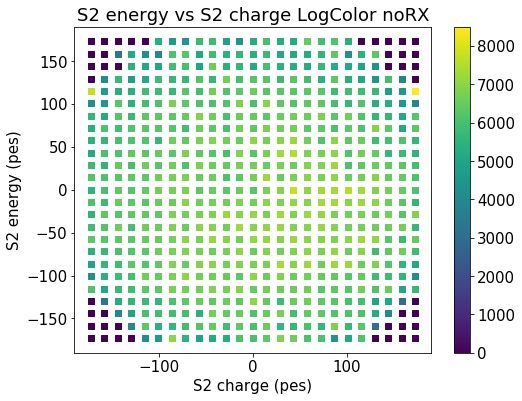

In [95]:
R = 180
data = filt_XR
data = data[data.Z<150]
profile_and_scatter(data.X, data.Y, data.S2e, [25,25], xrange=(-R,R),yrange=(-R,R))
#plt.colorbar().set_label("Average entries")
labels("S2 charge (pes)", "S2 energy (pes)")
save("S2 energy vs S2 charge LogColor noRX")

In [ ]:
'''
################################
s2e= filt_XR.S2e
hist(s2h/s2e, 50, range=(0, 1))
labels("Peak to area ratio (pes/pes)", "Entries")
save("S2peak2area")

################################
s2e= filt_XR.S2e
hist2d(filt_XR.Z, s2h/s2e, [100,50], range=([[0,250],[0, 1]]))
labels("Peak to area ratio (pes/pes)", "Entries")
save("S2peak2areavsZ")

################################
'''
s2w= filt_XR.S2w
hist2d(filt_XR.Z, s2w, [100,100], range=([[0,250],[0, 20]]))
labels("Drift time ($\mu$s)", "S2 width ($\mu$s)")
save("S2 width vs Z")


hist2d(filt_XR.S1e, filt_XR.S2e, [100,100], range=([[0,500],[0, 12e3]]))
labels("S1 energy (pes)", "S2 energy (pes)")
save("S2 energy vs S1 energy XR")

hist2d(full.S1e, full.S2e, [100,100], range=([[0,400],[0, 2e5]]))
labels("S1 energy (pes)", "S2 energy (pes)")
save("S2 energy vs S1 energy")

hist2d(full.S2q, full.S2e, [50,50], range=([[0,10e3],[0, 2e5]]), norm=LogNorm())
plt.colorbar().set_label("Average entries")
labels("S2 charge (pes)", "S2 energy (pes)")
save("S2 energy vs S2 charge LogColor")

hist2d(full[full.nS2==1].S2q, full[full.nS2==1].S2e, [50,50], range=([[0,10e3],[0, 2e5]]), norm=LogNorm())
plt.colorbar().set_label("Average entries")
labels("S2 charge (pes)", "S2 energy (pes)")
save("S2 energy vs S2 charge LogColor noRX")

hist2d(full.S2q, full.S2e, [50,50], range=([[0,10e3],[0, 2e5]]))
plt.colorbar().set_label("Average entries")
labels("S2 charge (pes)", "S2 energy (pes)")
save("S2 energy vs S2 charge")

hist2d(full[full.nS2==1].S2q, full[full.nS2==1].S2e, [50,50], range=([[0,10e3],[0, 2e5]]))
plt.colorbar().set_label("Average entries")
labels("S2 charge (pes)", "S2 energy (pes)")
save("S2 energy vs S2 charge noRX")

In [ ]:
################################
scatter(s1e, s2e)

labels("S1 energy (pes)", "S2 energy (pes)")
save("S2vsS1_RX")

In [ ]:
################################
scatter(filt_noXR.S1e, filt_noXR.S2e)

labels("S1 energy (pes)", "S2 energy (pes)")
save("S2vsS1_noRX")

In [ ]:
hist2d(full[full.Z<150].S1e, full[full.Z<150].S2e,[50,50],range=([[0,200],[1e4,20e4]]));

### Energy

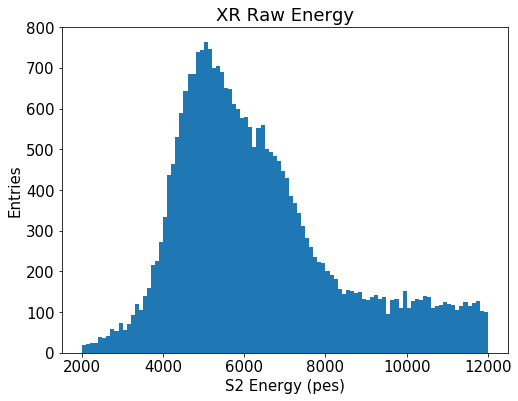

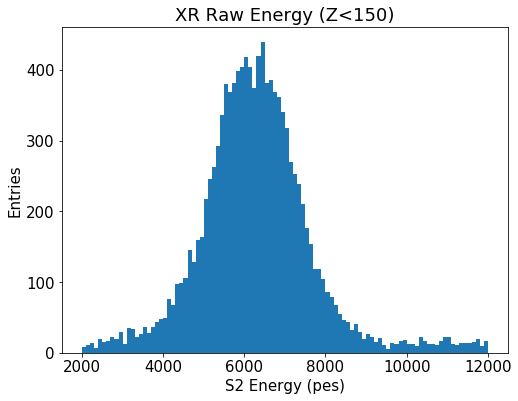

In [11]:
s2e = filt_XR.S2e
hist(s2e,100,[2000,12000])
labels("S2 Energy (pes)", "Entries")
save("XR Raw Energy")

hist(s2e[filt_XR.Z<150],100,[2000,12000])
labels("S2 Energy (pes)", "Entries")
save("XR Raw Energy (Z<150)")

In [18]:
fun = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:-1])+args[-1] 

/home/brais/Documents/Next/IC/IC-1/invisible_cities/core/fit_functions.py:123: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


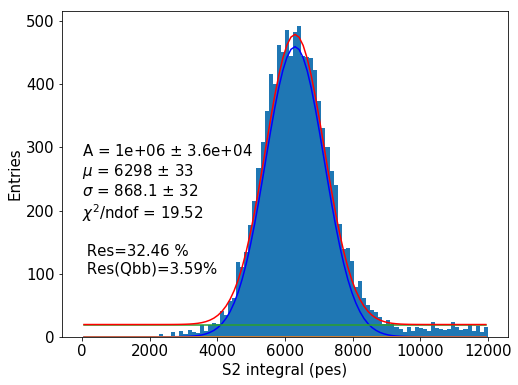

In [19]:
s2e = filt_XR[(filt_XR.R<180)&(filt_XR.Z<150)].S2e 
entries, xbins, _ = hist(s2e, 100, range=(0, 12e3))
xbins = get_centers(xbins)


f = fitf.fit(fun, xbins, entries,( 9e4, 6500, 500, 0, 9000, 500, 10),
                                            bounds=([8e4, 6000, 100, 0, 8000, 500, 0],
                                                    [10e5, 7000, 1000,0.01, 9500, 1000, 30]))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (30/2458)**0.5*res*100)

plt.text(0, 100, text, fontsize=15);
plt.plot(xbins, fitf.gauss(xbins, *f.values[:3]), "b-")
plt.plot(xbins, fitf.gauss(xbins, *f.values[3:-1]))
plt.plot(xbins, f.values[-1]*np.ones_like(xbins))
plt.plot(xbins, f.fn(xbins), fitOpt)


labels("S2 integral (pes)", "Entries")
#save("RX Raw (Z<150 R<180)")

# Z Correction 

FitFunction(fn=<function fit.<locals>.<lambda> at 0x7f17656411e0>, values=array([ 7921.74232786,  -425.24950843]), errors=array([ 79.03361612,  14.67858645]), chi2=2.9153109932616048)
7042.99243223


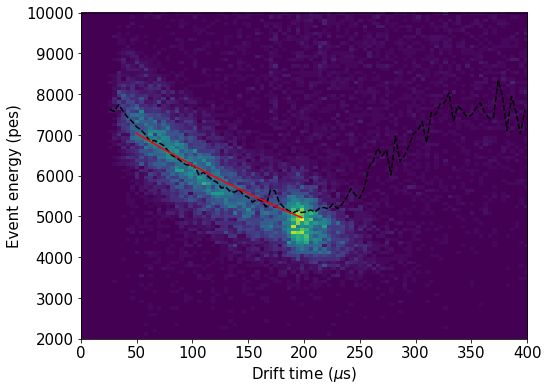

In [23]:
rcut = 175.0

xbin, ybin, z, axis = hist2d(filt_XR[filt_XR.R<rcut].Z, filt_XR[filt_XR.R<rcut].S2e, 100, [[0,400], [2000,10000]])
x, y, _ = fitf.profileX(filt_XR.Z[filt_XR.R<rcut], filt_XR.S2e[filt_XR.R<rcut], 100, xrange=[0,400], yrange=[2000,10000])
plt.plot(x, y, profOpt)
sel  = fitf.in_range(x, 50, 200)
x, y = x[sel], y[sel]
f = fitf.fit(fitf.expo, x, y, (1e5, -200))
plt.plot(x, f.fn(x), fitOpt)
print(f)
labels("Drift time ($\mu$s)", "Event energy (pes)")
#save("Energy vs Z")

zfun  = f.fn
zmin  = np.min(x)
zcorr = lambda z: zfun(zmin)/zfun(z)
print(zfun(zmin))

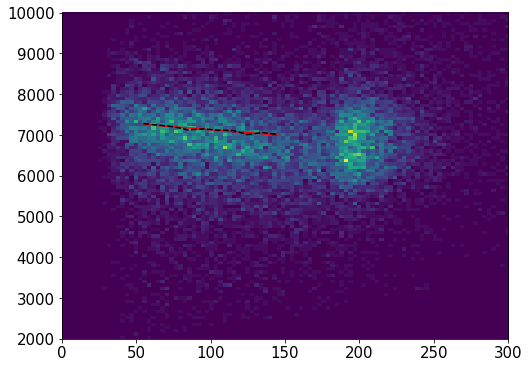

In [24]:
s2e = filt_XR.S2e * zcorr(filt_XR.Z)

xbin, ybin, z, axis = hist2d(filt_XR.Z, s2e, 100, [[0,300], [2000,10000]])
x, y, _ = fitf.profileX(filt_XR.Z, s2e, 30, xrange=[0,300], yrange=[6000,10000])
sel  = fitf.in_range(x, 50, 150)
x, y = x[sel], y[sel]
f = fitf.fit(fitf.expo, x, y, (1e5, -200))
plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, y, profOpt)




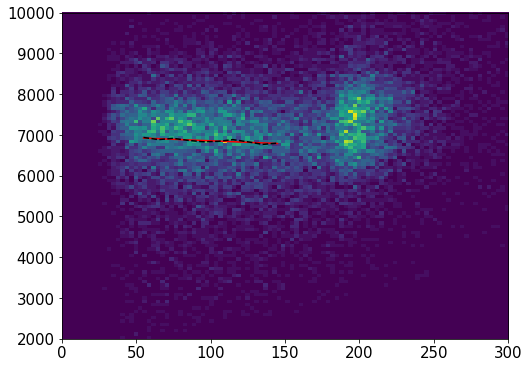

In [30]:
s2e = filt_XR.S2e * zcorr(filt_XR.Z)

xbin, ybin, z, axis = hist2d(filt_XR.Z, s2e, 100, [[0,300], [2000,10000]])
x, y, _ = fitf.profileX(filt_XR.Z, s2e, 30, xrange=[0,300], yrange=[2000,10000])
sel  = fitf.in_range(x, 50, 150)
x, y = x[sel], y[sel]
f = fitf.fit(fitf.expo, x, y, (1e5, -200))
plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, y, profOpt)

[  2.08791939e+06   6.98769823e+03   6.47407896e+02   7.04398081e+04
   8.63158655e+03   2.74375080e+02   1.96607730e+01]
res 0.218189959721 0.0241048509385


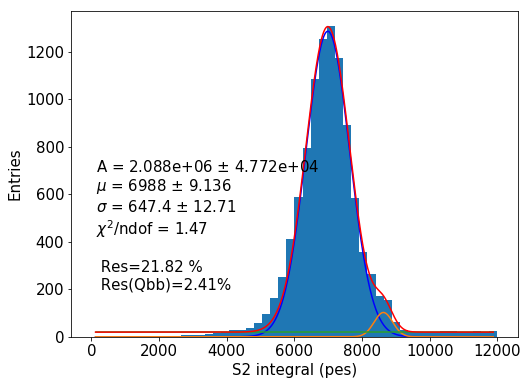

In [25]:
#Antes de Z=150

entries, xbins, _ = hist(s2e[(filt_XR.Z<150)&(filt_XR.R<180)], 50, range=(0e3, 12e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 6000, 10000)


f = fitf.fit(fun, xbins[selbins], entries[selbins],( 9e4, 6500, 500, 0, 8050, 200, 10),
                                            bounds=([8e4, 6000, 100, 0, 8000, 100, 0],
                                                    [10e6, 9000, 10000,1e5, 9000, 1e3, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.4g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (30/2458)**0.5*res*100)


xrange = np.linspace(xbins[0],xbins[-1],1000)
plt.text(min(xbins), 200, text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]))
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)

labels("S2 integral (pes)", "Entries")
#save("RX ZCorr (Z<150 R<180)")

[  1.29431468e+06   6.79589716e+03   7.63668496e+02   1.00000000e+04
   9.99999999e+03   2.00000000e+03   9.27691598e+01]
res 0.26463603903 0.0292360486336


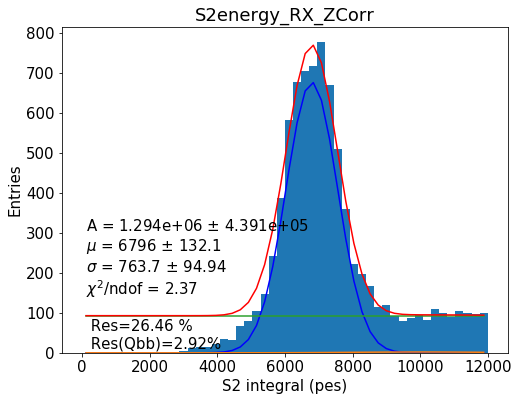

In [26]:
entries, xbins, _ = hist(s2e[filt_XR.Z>175], 50, range=(0e3, 12e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 6000, 12000)


f = fitf.fit(fun, xbins[selbins], entries[selbins],( 9e4, 8000, 500, 9e4, 8550, 500, 10),
                                            bounds=([8e4, 6000, 100, 1e4, 8000, 500, 0],
                                                    [10e6, 9000, 1000,10e5, 10000, 2000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.4g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (30/2458)**0.5*res*100)

plt.text(min(xbins), 10, text, fontsize=15);
plt.plot(xbins, fitf.gauss(xbins, *f.values[:3]), "b-")
plt.plot(xbins, fitf.gauss(xbins, *f.values[3:-1]))
plt.plot(xbins, f.values[-1]*np.ones_like(xbins))
plt.plot(xbins, f.fn(xbins), fitOpt)


labels("S2 integral (pes)", "Entries")
save("S2energy_RX_ZCorr")

## R correction

In [ ]:
xbin, ybin, z, axis = hist2d(filt_XR[filt_XR.Z<100].R, s2e[filt_XR.Z<100], 100, [[0,250], [2000,10000]])
x, y, _ = fitf.profileX(filt_XR[filt_XR.Z<150].R, s2e[filt_XR.Z<150], 30, xrange=[0,200], yrange=[3000,10000])
plt.plot(x, y, profOpt)
sel  = fitf.in_range(x, 50, 180)
x, y = x[sel], y[sel]
f = fitf.fit(fitf.polynom, x, y, (6000,-200, -200))
plt.plot(x, f.fn(x), fitOpt)
print(f.values)
labels("R (mm)", "Event energy (pes)")
save("Energy vs R")

rfun  = f.fn
rmin  = np.min(x)
rcorr = lambda r: rfun(rmin)/rfun(r)
print(rfun(rmin))

In [ ]:
r_s2e = s2e[(filt_XR.Z<150)&(filt_XR.R<180)] * rcorr(filt_XR[(filt_XR.Z<150)&(filt_XR.R<180)].R)

xbin, ybin, z, axis = hist2d(filt_XR[(filt_XR.Z<150)&(filt_XR.R<180)].R, r_s2e, 100, [[0,250], [2000,10000]])
x, y, _ = fitf.profileX(filt_XR[(filt_XR.Z<150)&(filt_XR.R<180)].R, r_s2e, 30, xrange=[0,200], yrange=[3000,10000])
plt.plot(x, y, profOpt)
sel  = fitf.in_range(x, 50, 200)
x, y = x[sel], y[sel]
f = fitf.fit(fitf.polynom, x, y, (6000,-200, -200))
plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, y, profOpt)


entries, xbins, _ = hist(r_s2e, 50, range=(3e3, 10e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 6.55e3, 12e3)


f = fitf.fit(fun, xbins[selbins], entries[selbins],( 10e4, 7000, 500, 9e4, 8550, 500, 10),
                                            bounds=([8e4, 6000, 100, 1e4, 8500, 100, 0],
                                                    [10e6, 8000, 1000,15e5, 10000, 2000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (30/2458)**0.5*res*100)

xrange = np.linspace(xbins[0],xbins[-1],1000)
plt.text(min(xbins), 200, text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]))
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)

labels("S2 integral (pes)", "Entries")
save("RX RCorr (Z<150 R<180)")

In [ ]:
r_s2e_ = s2e[(filt_XR.Z>175)&(filt_XR.R<180)] * rcorr(filt_XR[(filt_XR.Z>175)&(filt_XR.R<180)].R)

xbin, ybin, z, axis = hist2d(filt_XR[(filt_XR.Z>175)&(filt_XR.R<180)].R, r_s2e_, 100, [[0,250], [2000,10000]])
x, y, _ = fitf.profileX(filt_XR[(filt_XR.Z>175)&(filt_XR.R<180)].R, r_s2e_, 30, xrange=[0,200], yrange=[3000,10000])
plt.plot(x, y, profOpt)
sel  = fitf.in_range(x, 50, 200)
x, y = x[sel], y[sel]
f = fitf.fit(fitf.polynom, x, y, (6000,-200, -200))
plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, y, profOpt)


entries, xbins, _ = hist(r_s2e_, 50, range=(4e3, 12e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 6.5e3, 12e3)


f = fitf.fit(fun, xbins[selbins], entries[selbins],( 10e4, 7000, 500, 9e4, 8550, 500, 10),
                                            bounds=([8e4, 6000, 100, 1e4, 8500, 100, 0],
                                                    [10e6, 8000, 1000,15e5, 10000, 2000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.4g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (30/2458)**0.5*res*100)

plt.text(min(xbins), 30, text, fontsize=15);
plt.plot(xbins, fitf.gauss(xbins, *f.values[:3]), "b-")
plt.plot(xbins, fitf.gauss(xbins, *f.values[3:-1]))
plt.plot(xbins, f.values[-1]*np.ones_like(xbins))
plt.plot(xbins, f.fn(xbins), fitOpt)


labels("S2 integral (pes)", "Entries")
save("S2energy_RX_RCorrZmax")

# Phi

In [ ]:
r_s2e = s2e[(filt_XR.Z<150)&(filt_XR.R<180)] * rcorr(filt_XR[(filt_XR.Z<150)&(filt_XR.R<180)].R)

xbin, ybin, z, axis = hist2d(filt_XR[(filt_XR.Z<150)&(filt_XR.R<180)].Phi, r_s2e, 100, [[-pi,pi], [5000,10000]])
x, y, _ = fitf.profileX(filt_XR[(filt_XR.Z<150)&(filt_XR.R<180)].Phi, r_s2e, 25, xrange=[-pi,pi], yrange=[5000,10000])
plt.plot(x, y, profOpt)
def get_phicorr(T, E):
    eref = np.max(E)
    def phicorr(t):
        dt = np.abs(t[:, np.newaxis]-T)
        return eref / E[np.apply_along_axis(np.argmin, 1, dt)]
    return phicorr
phicorr = get_phicorr(x, y) 
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi_Z")

In [ ]:
rphi_s2e = r_s2e * phicorr(filt_XR[(filt_XR.Z<150)&(filt_XR.R<180)].Phi)

#xbin, ybin, z, axis = hist2d(filt_XR[(filt_XR.Z<150)&(filt_XR.R<180)].Phi, rphi_s2e, 100, [[-pi,+pi], [5000,10000]])
#x, y, _ = fitf.profileX(filt_XR[(filt_XR.Z<150)&(filt_XR.R<180)].Phi, rphi_s2e, 30, xrange=[-pi,pi], yrange=[5000,10000])
#plt.plot(x, y, profOpt)
#sel  = fitf.in_range(x, 50, 200)
#x, y = x[sel], y[sel]
#f = fitf.fit(fitf.polynom, x, y, (6000,-200, -200))
#plt.plot(x, f.fn(x), fitOpt)
#plt.plot(x, y, profOpt)


entries, xbins, _ = hist(rphi_s2e, 50, range=(4e3, 11e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 6.5e3, 12e3)


f = fitf.fit(fun, xbins[selbins], entries[selbins],( 10e4, 7000, 500, 9e4, 8550, 500, 10),
                                            bounds=([8e4, 6000, 100, 1e4, 8500, 100, 0],
                                                    [10e6, 8000, 1000,15e5, 10000, 2000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (29.6/2458)**0.5*res*100)

xrange = np.linspace(4e3, 11e3,1000)

plt.text(min(xbins)-100, 400, text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-")
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]))
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), "k-")


labels("S2 integral (pes)", "Entries")
save("RX ZRPhiCorr (Z<150 R<180)")

In [ ]:
rphi_s2e_c = r_s2e[(filt_XR.Z<150)&(filt_XR.R<100)] * phicorr(filt_XR[(filt_XR.Z<150)&(filt_XR.R<100)].Phi)


entries, xbins, _ = hist(rphi_s2e_c, 50, range=(4e3, 11e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 6.5e3, 12e3)


f = fitf.fit(fun, xbins[selbins], entries[selbins],( 10e4, 7000, 500, 9e4, 8550, 500, 10),
                                            bounds=([8e4, 6000, 100, 1e4, 8500, 100, 0],
                                                    [10e6, 8000, 1000,15e5, 10000, 2000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res = {:.2f} % \n Res(Qbb) = {:.2f}% ".format(res*100, (29.6/2458)**0.5*res*100)

xrange = np.linspace(4e3, 11e3,1000)

plt.text(min(xbins)-100, 200, text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-")
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]))
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), "k-")


labels("S2 integral (pes)", "Entries")
save("RX ZRPhiCorr (Z<150 R<100)")

# XY corrections

7103.90886827


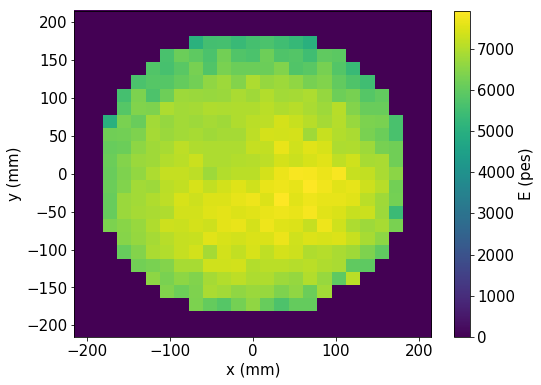

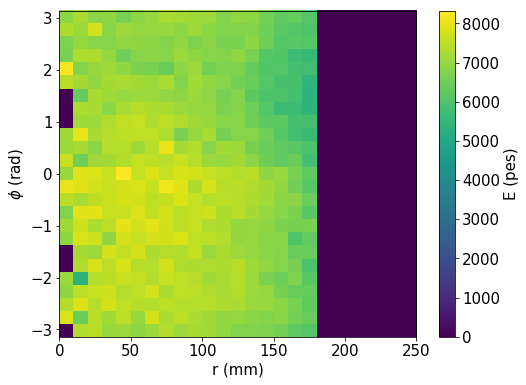

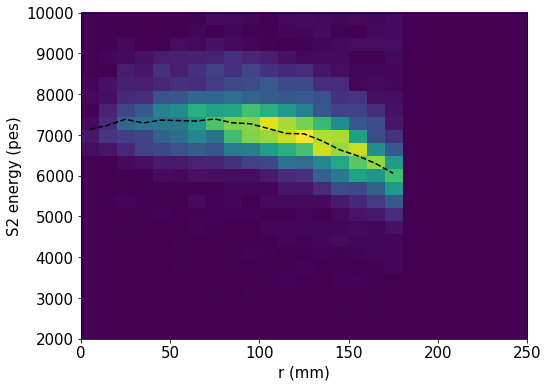

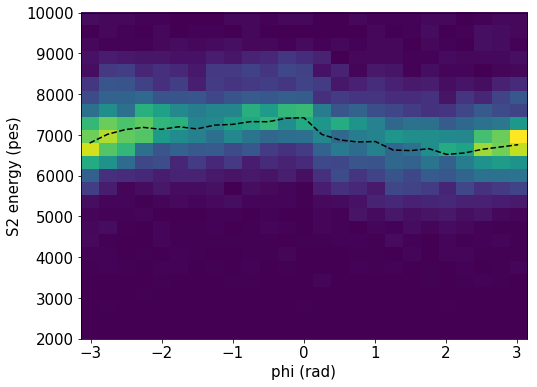

In [29]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 250
prange = - pi,  pi
Erange =  2e3, 10e3
nbin = 25

#data = filt_XR[filt_XR.Z<150][:]
data = filt_XR[(filt_XR.Z<150)&(filt_XR.R<180)][:]
data =  data[data.S2e * zcorr(data.Z)<10e3]
Ez  = data.S2e * zcorr(data.Z)


pf, _, cb = profile_and_scatter(data.X, data.Y, Ez, (nbin, nbin), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
#save("EvsXY")

_, _, cb = profile_and_scatter(data.R, data.Phi, Ez, (nbin, nbin), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
#save("EvsRPhi")

hist2d(data.R, Ez, (nbin, nbin), range=(rrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.R, Ez, nbin, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
#save("EvsR")

hist2d(data.Phi, Ez, (nbin, nbin), range=(prange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.Phi, Ez, nbin, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
#save("EvsPhi")

'''
np.savetxt('xycorr_xs_3614.dat',np.array(pf[0]))
np.savetxt('xycorr_ys_3614.dat',np.array(pf[1]))
np.savetxt('xycorr_es_3614.dat',np.array(pf[2]))
'''



def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr
xycorr = get_xycorr(*pf[:-1])

In [ ]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 250
prange = - pi,  pi
Erange =  2e3, 10e3


data = filt_XR[(filt_XR.Z>0)&(filt_XR.R<180)][:]

Ez  = data.S2e * zcorr(data.Z) * xycorr(data.X.values, data.Y.values)


#filt_XR[filt_XR.Z<150].X[:], filt_XR[filt_XR.Z<150].Y[:]

pf, _, cb = profile_and_scatter(data.X, data.Y, Ez, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY_corXYZ")

_, _, cb = profile_and_scatter(data.R, data.Phi, Ez, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi_corXYZ")

hist2d(data.R, Ez, (50, 50), range=(rrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.R, Ez, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR_corXYZ")

hist2d(data.Phi, Ez, (50, 50), range=(prange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.Phi, Ez, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi_corXYZ")

hist2d(data.Z, Ez, (50, 50), range=([0,250], Erange), weights=Ez)
x, y, _ = fitf.profileX(data.Z, Ez, 50, xrange=[0,150], yrange=Erange)
plt.plot(x, y, profOpt)
labels("Z (mus)", "S2 energy (pes)")
save("EvsZ_corXYZ")


In [2]:
data = filt_XR[(filt_XR.Z<150)&(filt_XR.R<100)][:]

Ez_  = data.S2e * zcorr(data.Z) * xycorr(data.X.values, data.Y.values)

entries, xbins, _ = hist(Ez_, 50, range=(4e3, 11e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 6.5e3, 9e3)


f = fitf.fit(fun, xbins[selbins], entries[selbins],( 10e4, 7000, 500, 9e4, 8050, 500, 0),
                                            bounds=([8e4, 6000, 100, 1e4, 7000, 100, 0],
                                                    [10e6, 8000, 1000,15e5, 10000, 2000, 100] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values,"\n",f.errors)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("$\mu$ $\sigma$".split(),
                                            f.values[1:],
                                            f.errors[1:])] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (29.6/2458)**0.5*res*100)

xrange = np.linspace(4e3, 11e3,1000)

plt.text(min(xbins)-100, 400, text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=2)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)


labels("S2 integral (pes)", "Entries")
#save("RX XYZ Corr (Z<150 R<180)")

NameError: name 'filt_XR' is not defined

[  2.60196449e+05   7.11306890e+03   2.46534636e+02   8.64154259e+04
   8.02116349e+03   3.49484047e+02   7.90392183e-07] 
 [  9.89880919e+03   8.05286361e+00   7.42459806e+00   1.62962135e+04
   3.75667678e+01   5.02315785e+01   8.69057350e+00]
res 0.0816228658797 0.00901740399843


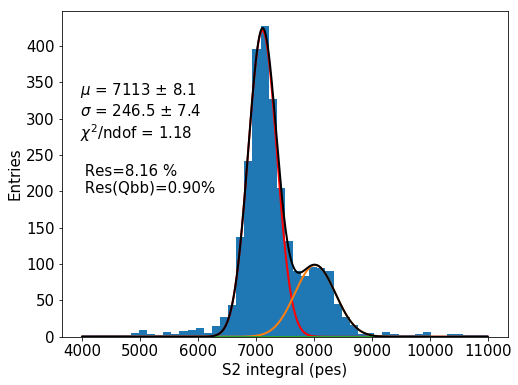

In [63]:
data = filt_XR[(filt_XR.Z<150)&(filt_XR.R<83)][:]

Ez_  = data.S2e * zcorr(data.Z) * xycorr(data.X.values, data.Y.values)

entries, xbins, _ = hist(Ez_, 50, range=(4e3, 11e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 6.5e3, 9e3)


f = fitf.fit(fun, xbins[selbins], entries[selbins],( 10e4, 7000, 500, 9e4, 8050, 250, 0),
                                            bounds=([8e4, 6000, 100, 1e4, 7000, 100, 0],
                                                    [10e6, 8000, 1000,15e5, 10000, 500, 100] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values,"\n",f.errors)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("$\mu$ $\sigma$".split(),
                                            f.values[1:],
                                            f.errors[1:])] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (29.6/2458)**0.5*res*100)

xrange = np.linspace(4e3, 11e3,1000)

plt.text(min(xbins)-100, 200, text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=2)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)


labels("S2 integral (pes)", "Entries")
#save("RX XYZ Corr (Z<150 R<100)")

In [ ]:
data = filt_XR[(filt_XR.Z<150)&(filt_XR.X<-10)&(filt_XR.X>-100)][:]

Ez_  = data.S2e * zcorr(data.Z) * xycorr(data.X.values, data.Y.values)

entries, xbins, _ = hist(Ez_, 50, range=(4e3, 11e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 6.5e3, 10e3)


f = fitf.fit(fun, xbins[selbins], entries[selbins],( 10e4, 7000, 500, 9e4, 8050, 500, 0),
                                            bounds=([8e4, 6000, 100, 1e4, 7000, 100, 0],
                                                    [10e6, 8000, 1000,15e5, 10000, 2000, 100] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values,"\n",f.errors)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("$\mu$ $\sigma$".split(),
                                            f.values[1:],
                                            f.errors[1:])] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (29.6/2458)**0.5*res*100)

xrange = np.linspace(4e3, 11e3,1000)

plt.text(min(xbins)-100, 400, text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=3)
plt.plot(xrange, fitf.gauss(xrangege, *f.values[3:-1]), linewidth=3)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=3)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=3)


labels("S2 integral (pes)", "Entries")
#save("S2energy_RX_XYZ_Corr")

/home/brais/Documents/Next/IC/IC-1/invisible_cities/core/fit_functions.py:123: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))
/home/brais/miniconda/envs/IC3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 100 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


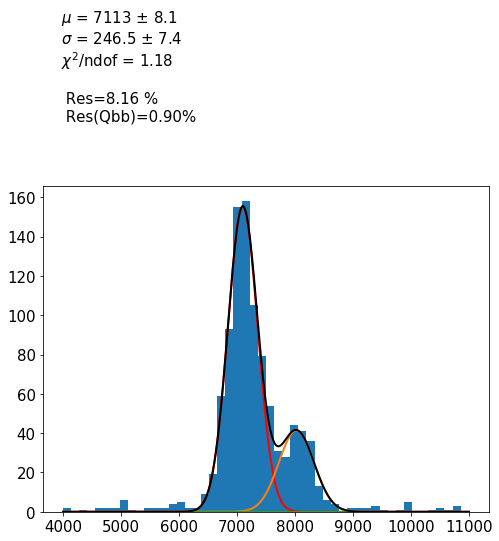

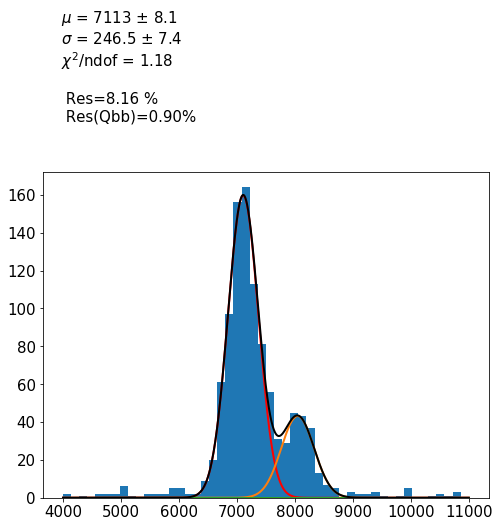

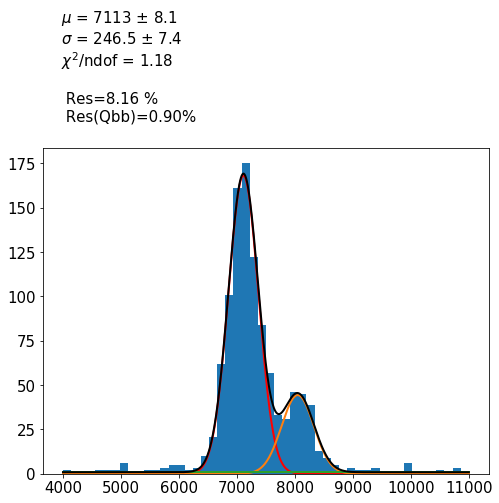

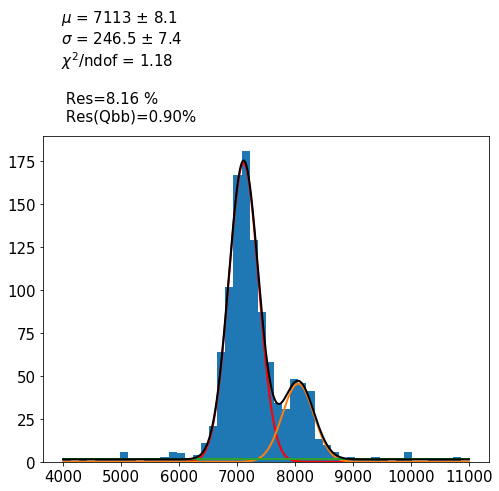

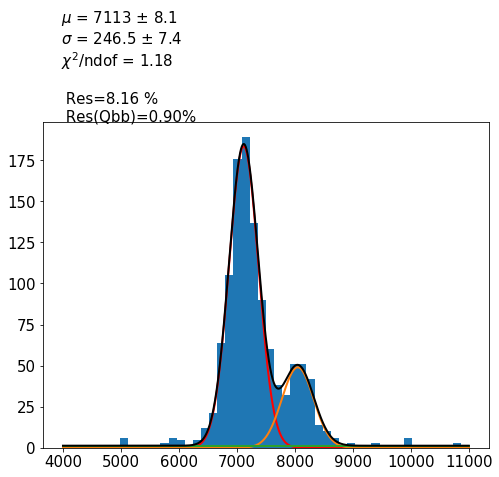

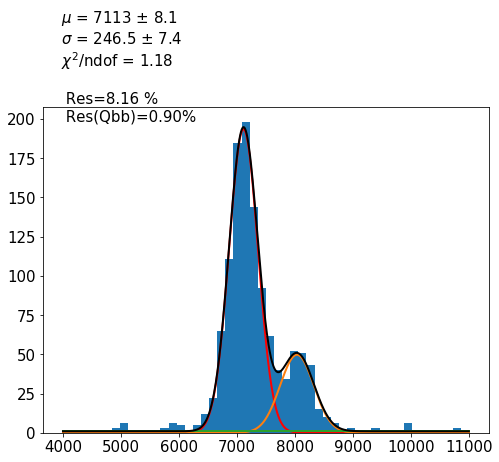

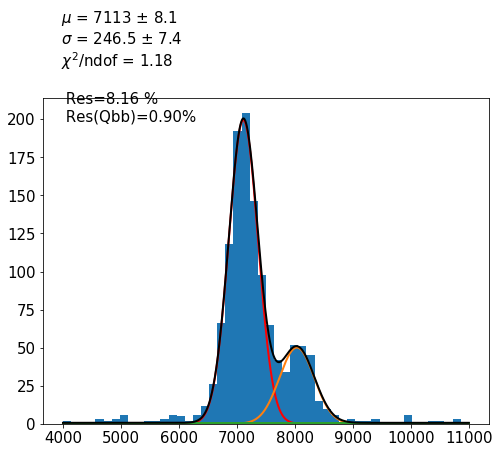

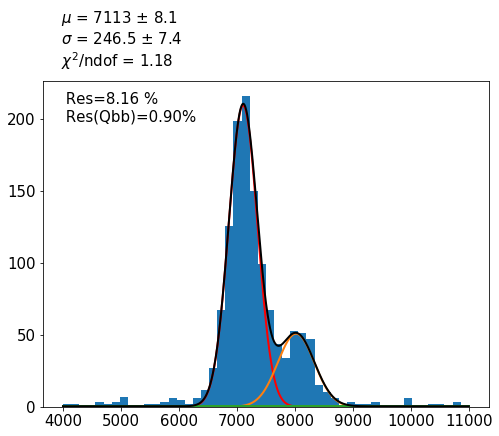

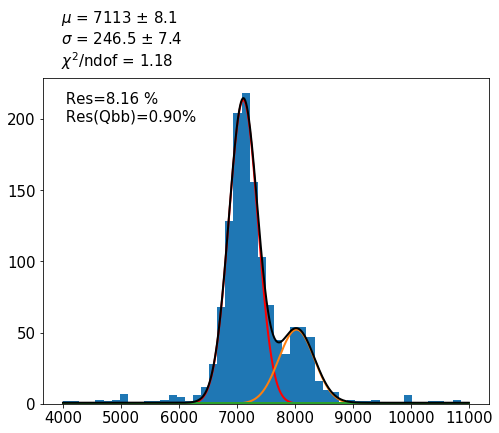

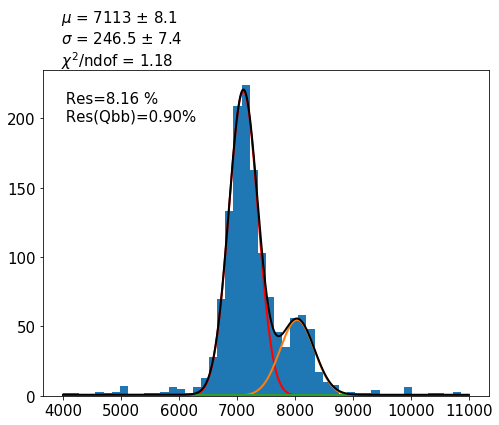

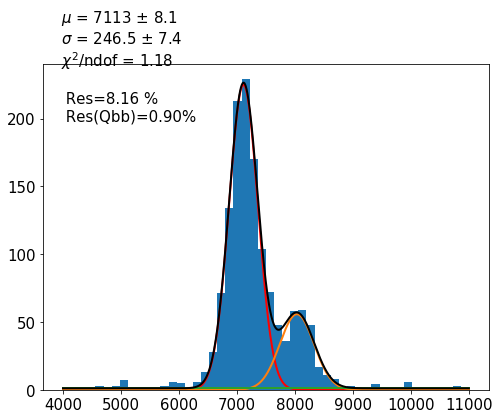

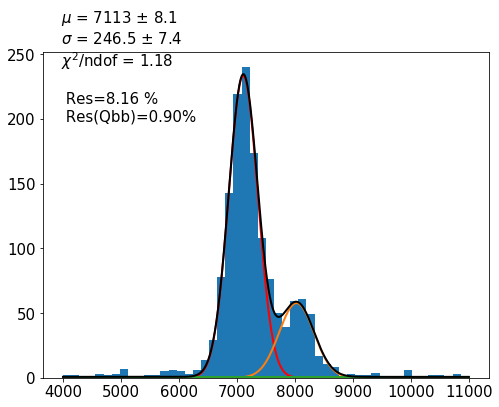

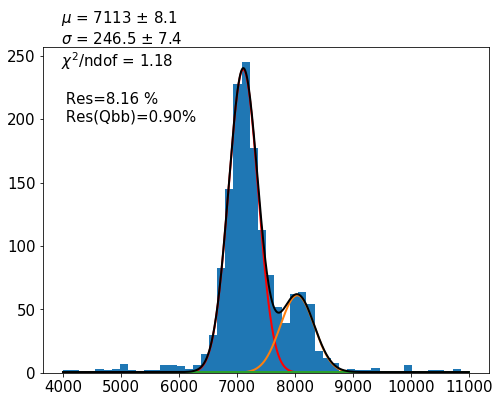

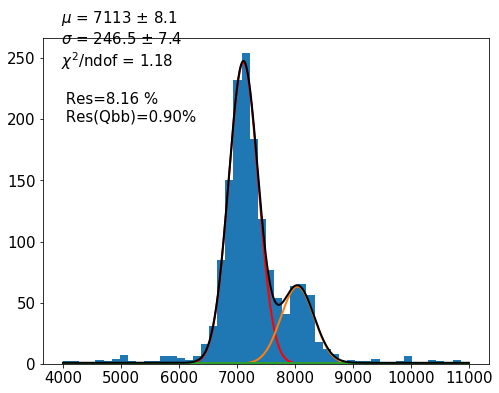

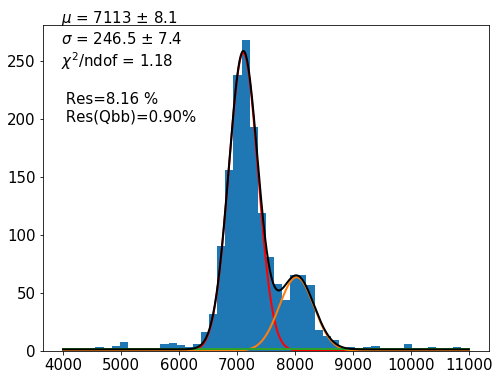

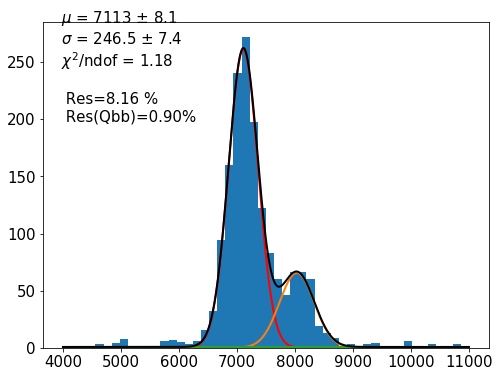

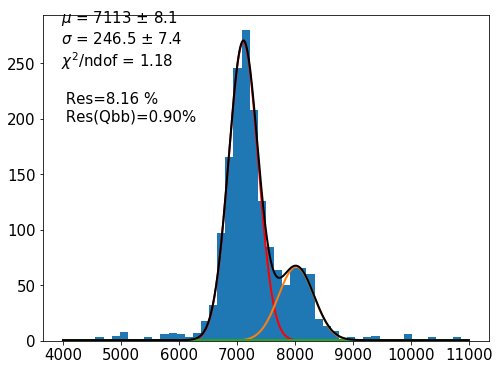

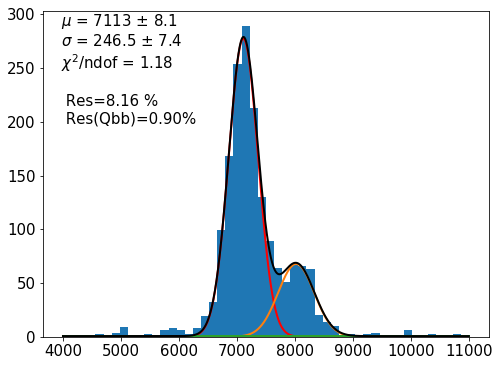

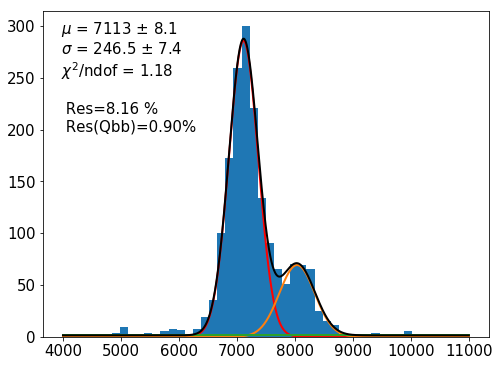

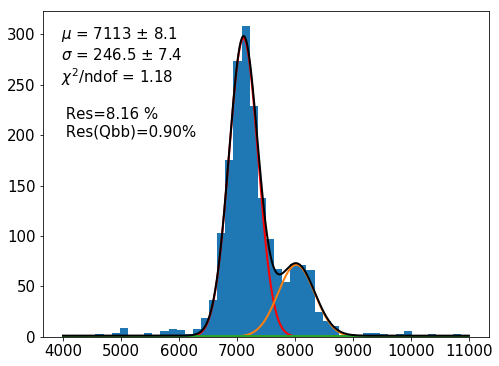

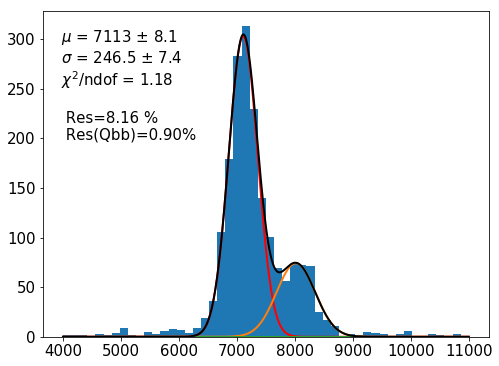

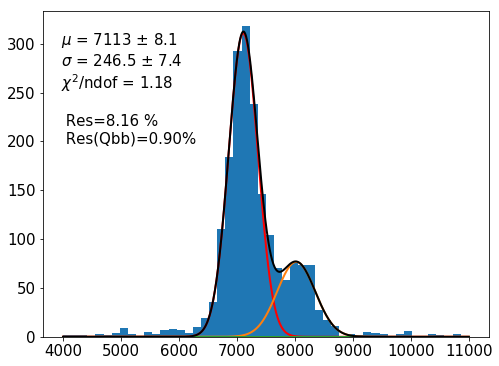

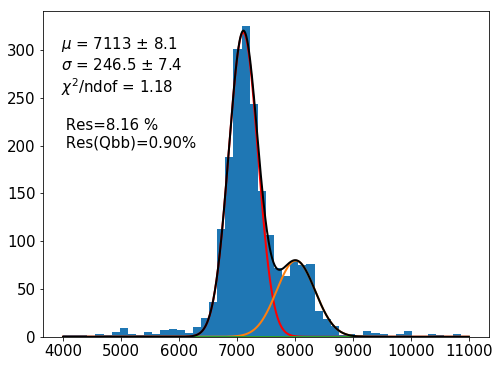

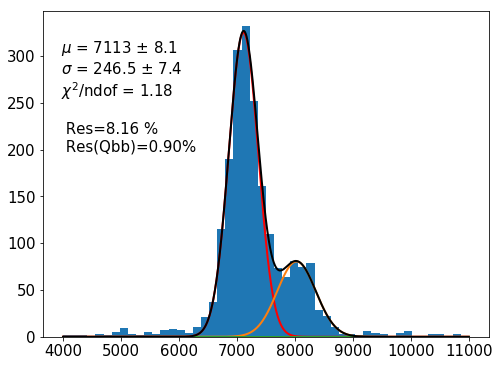

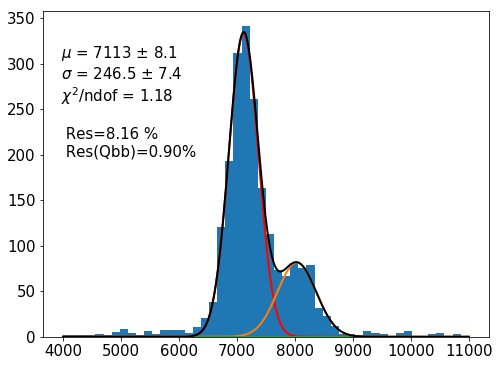

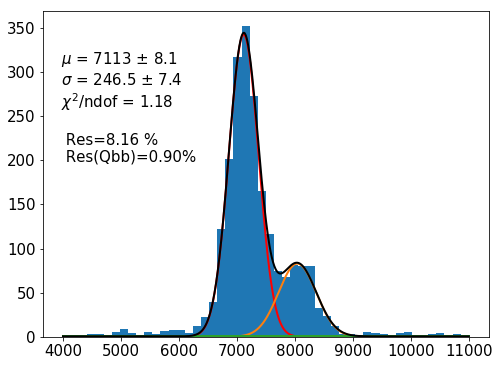

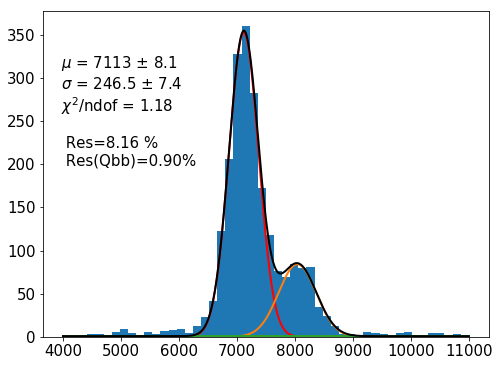

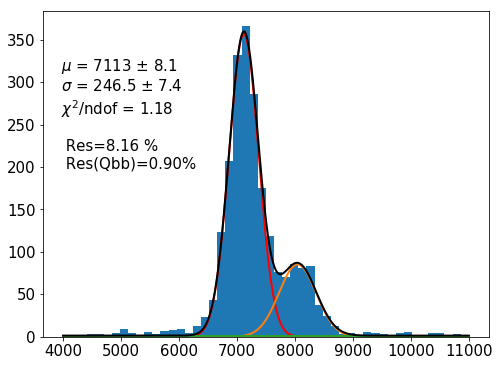

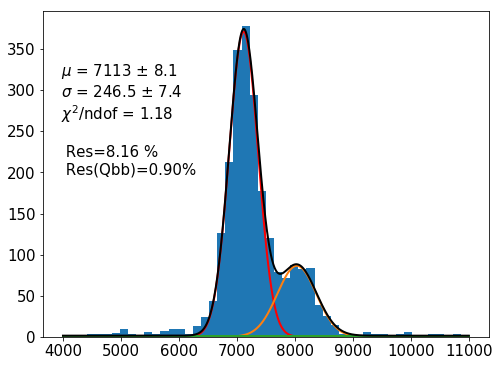

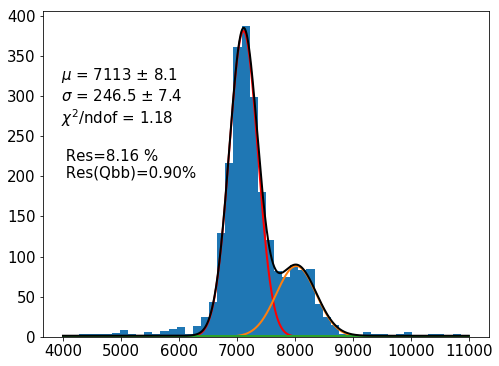

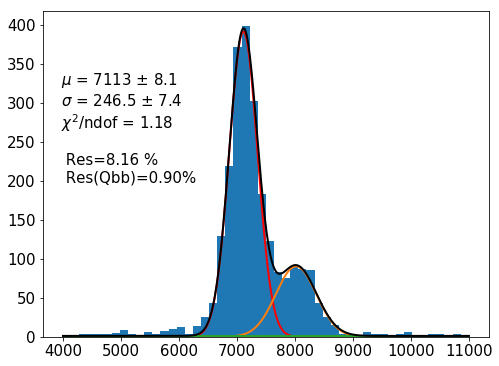

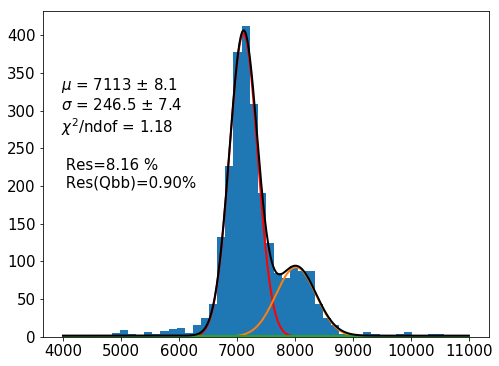

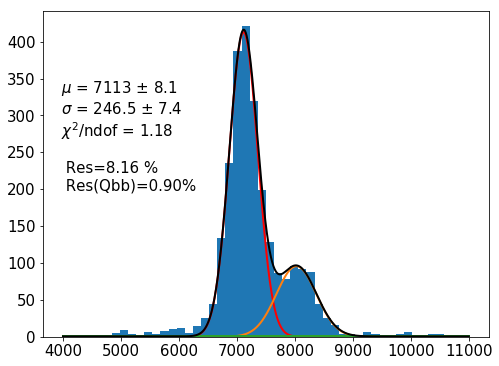

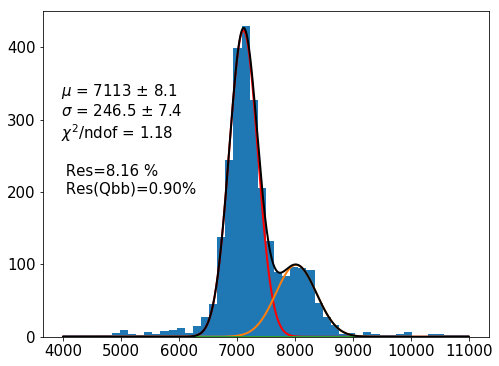

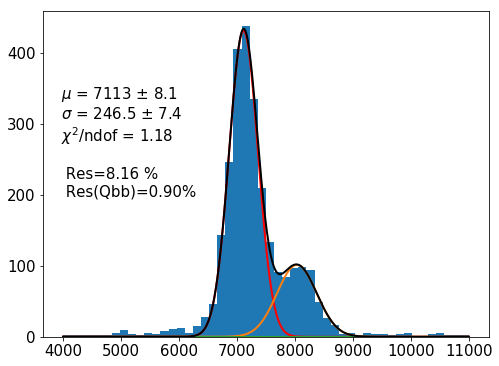

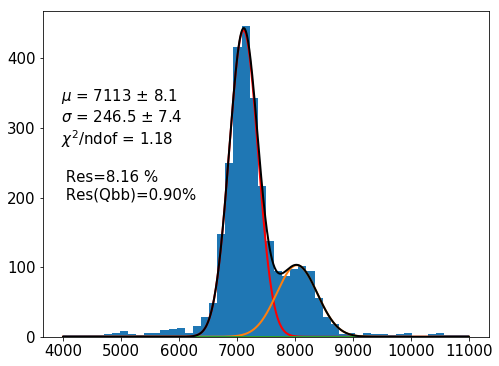

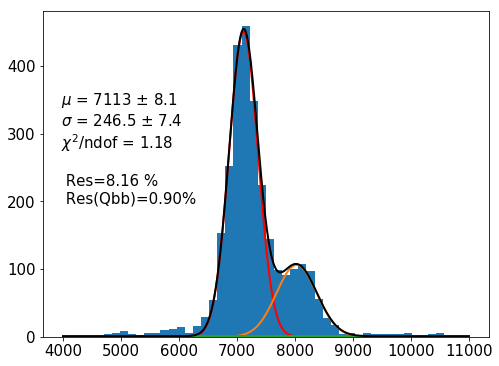

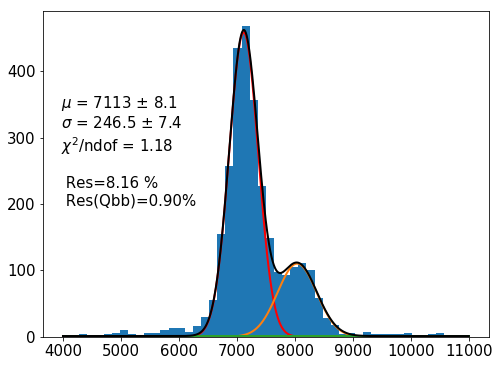

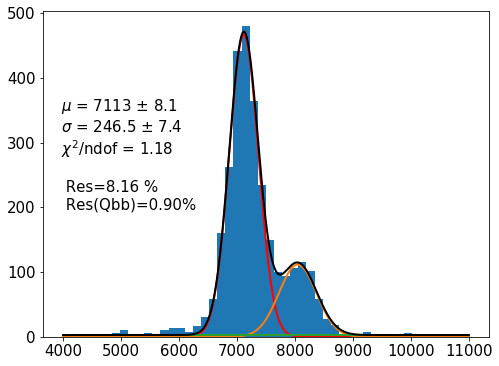

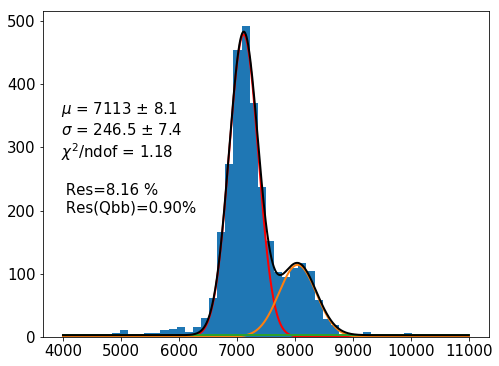

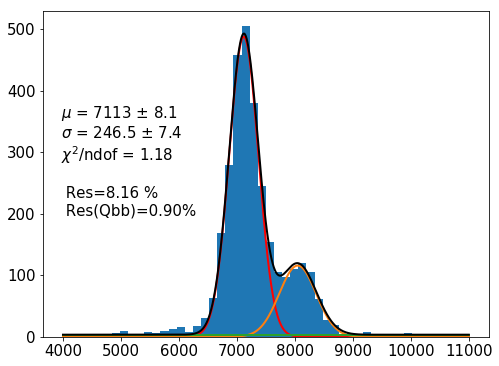

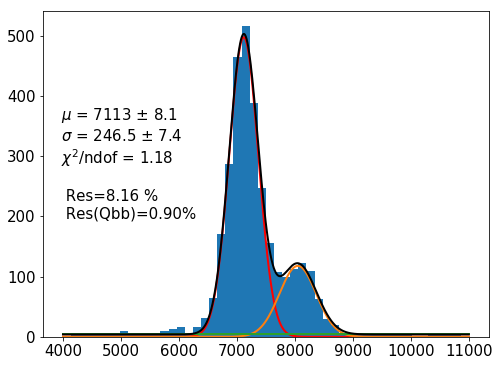

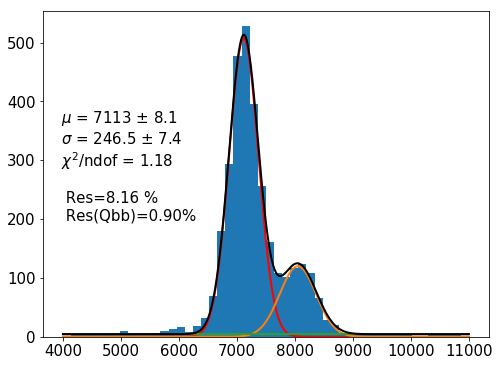

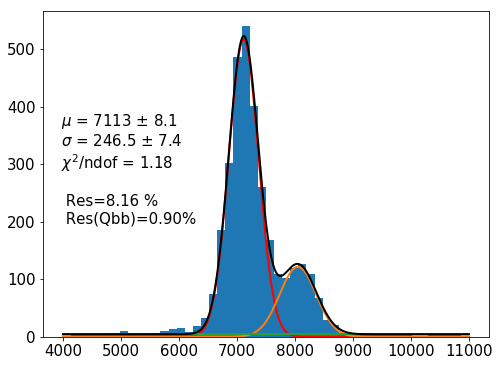

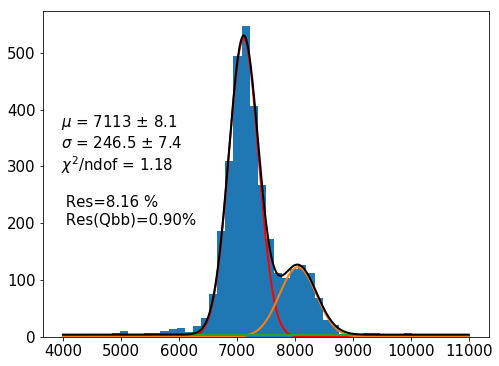

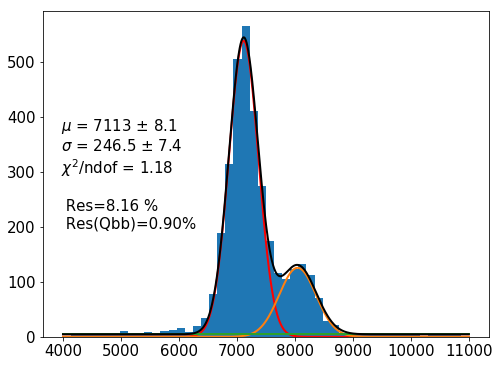

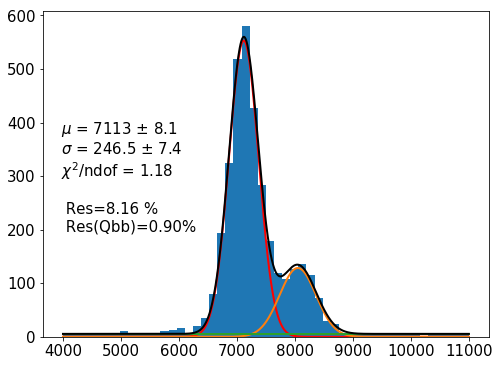

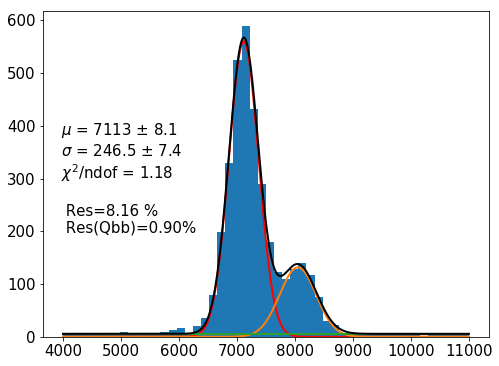

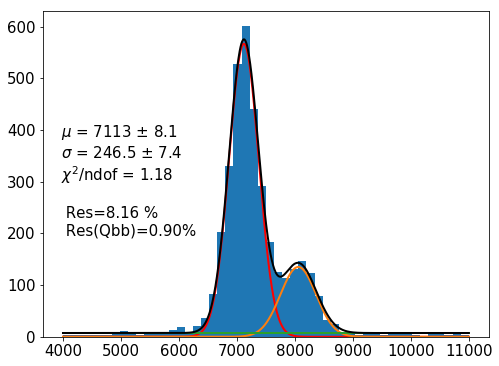

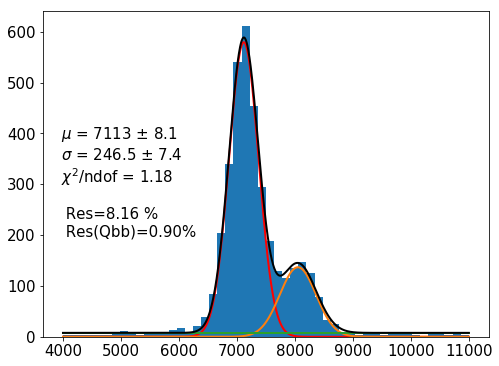

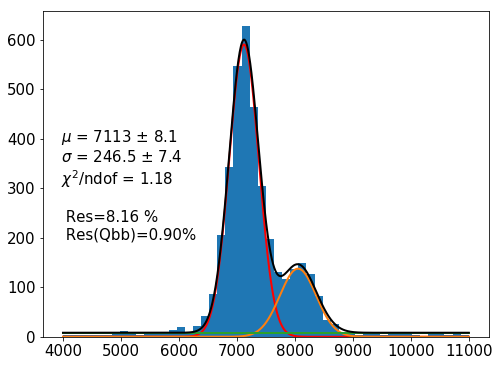

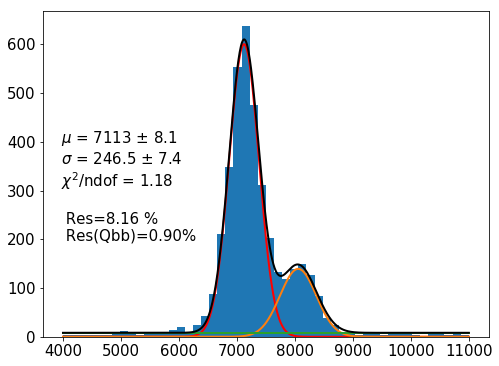

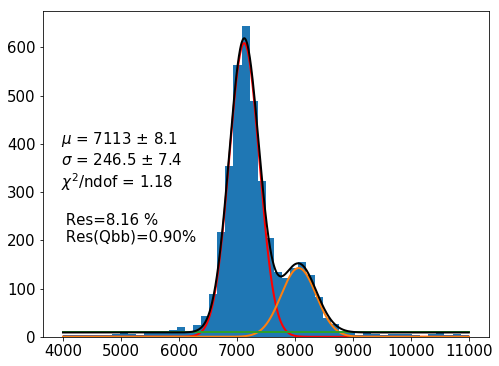

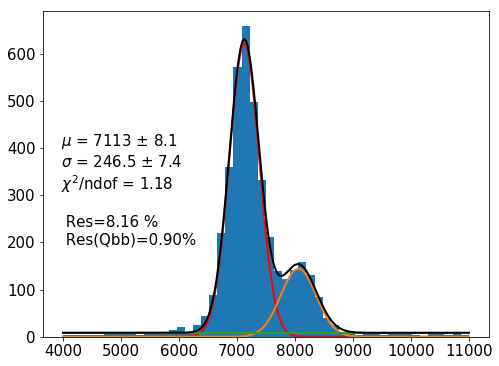

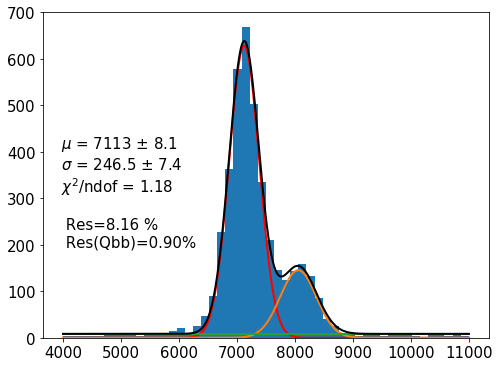

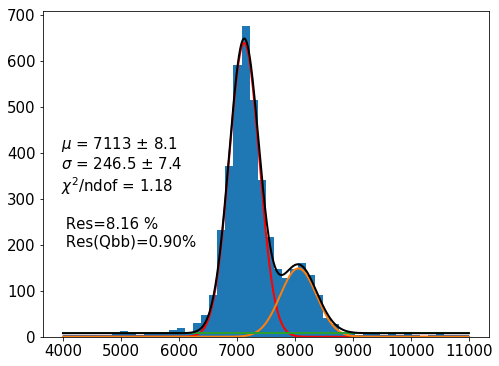

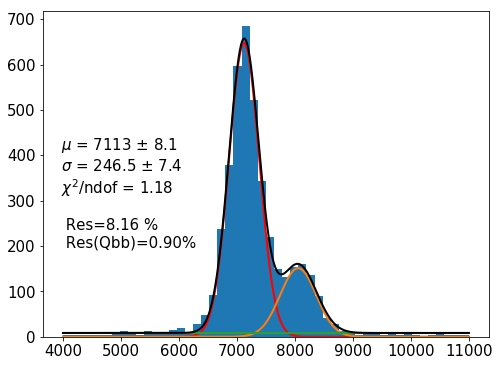

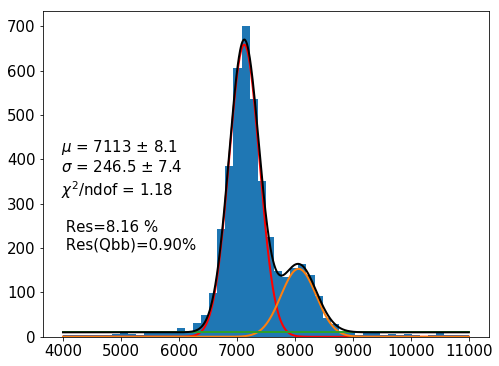

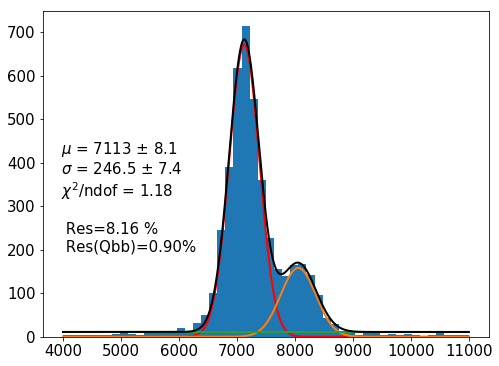

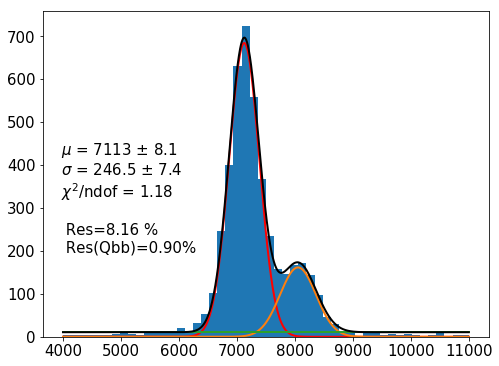

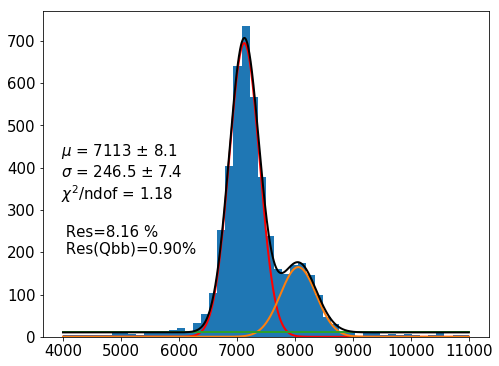

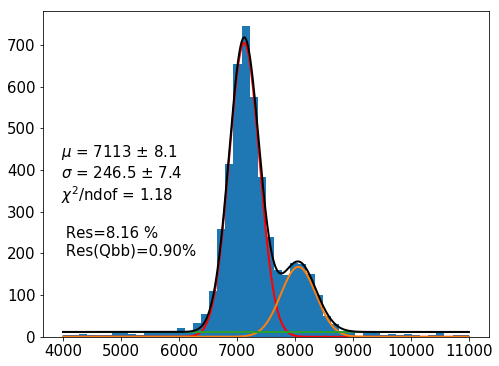

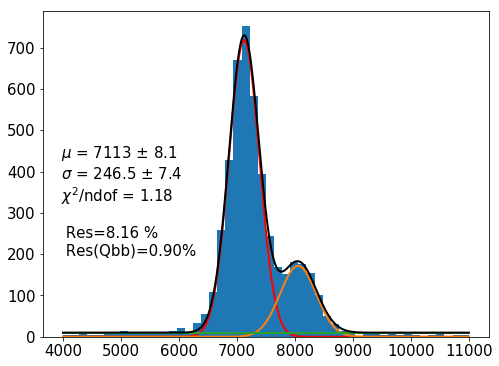

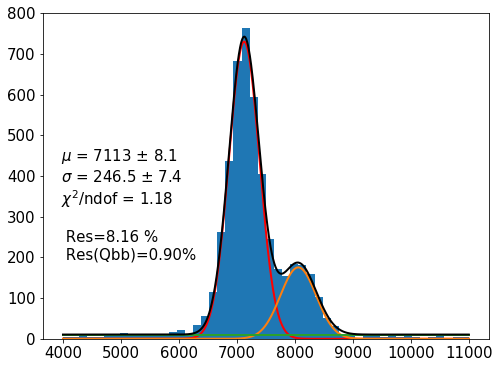

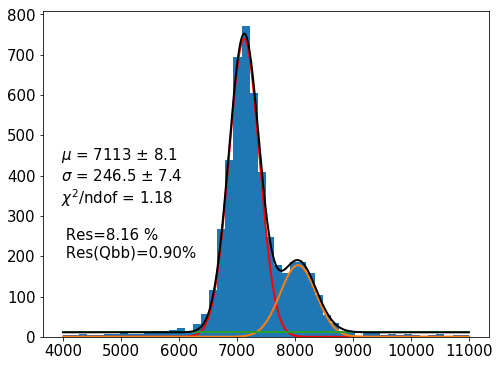

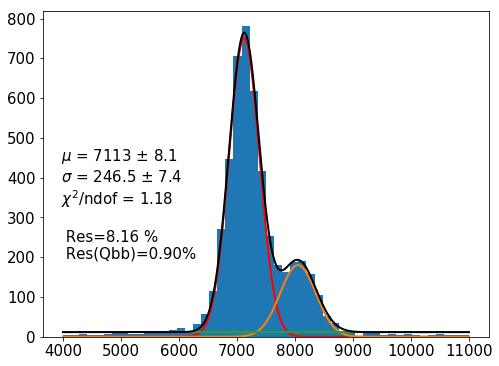

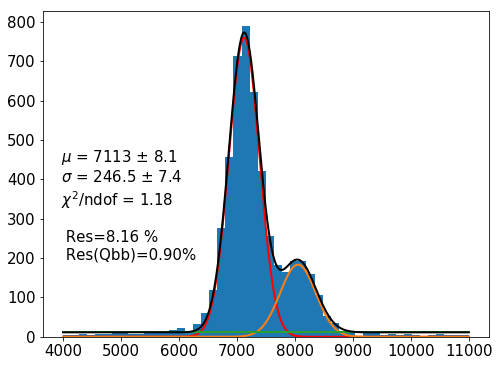

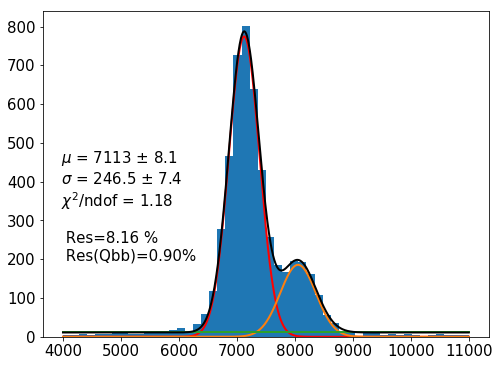

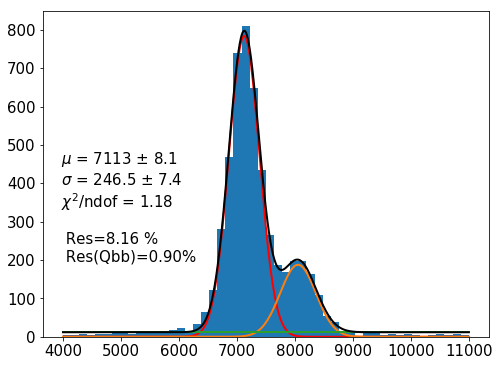

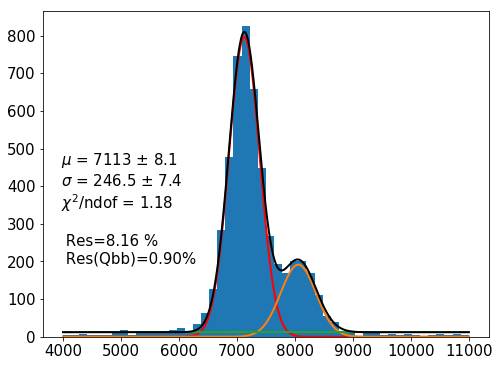

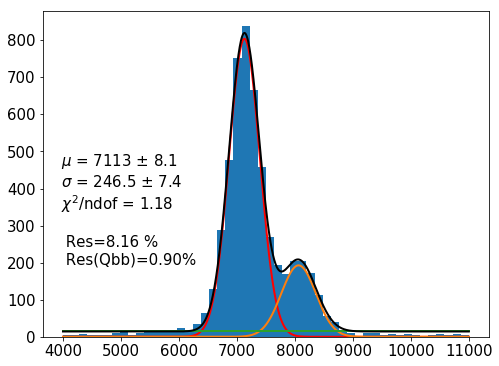

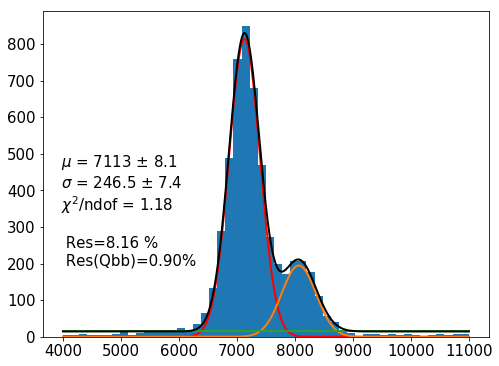

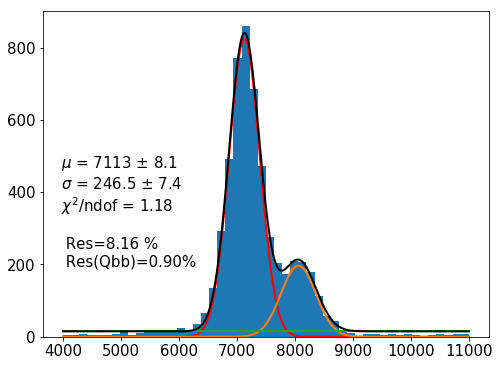

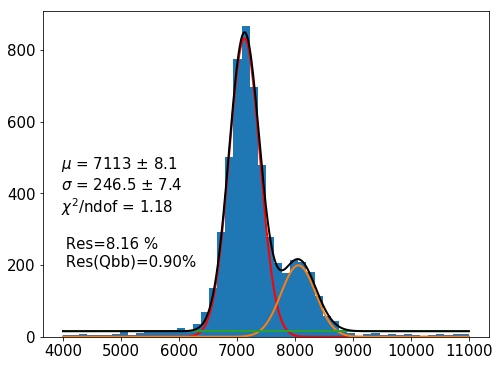

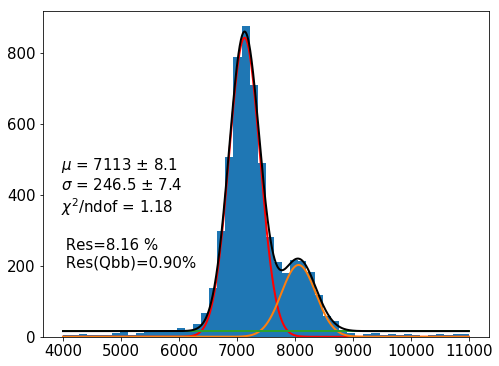

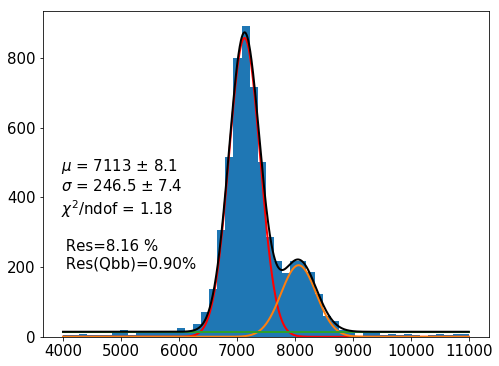

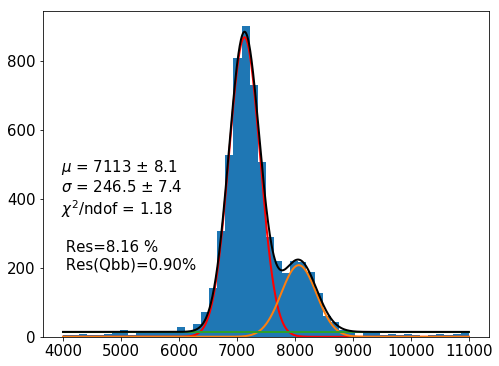

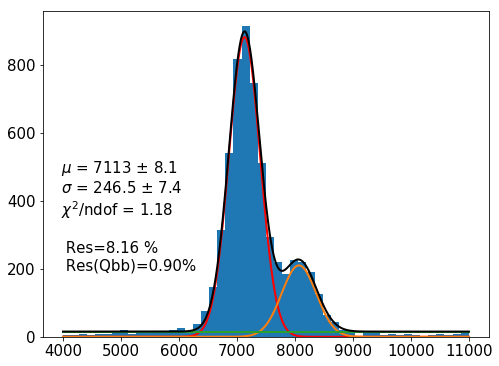

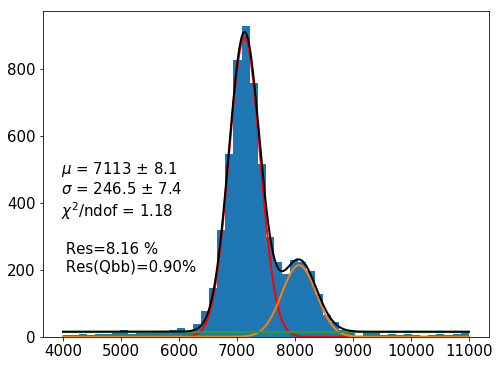

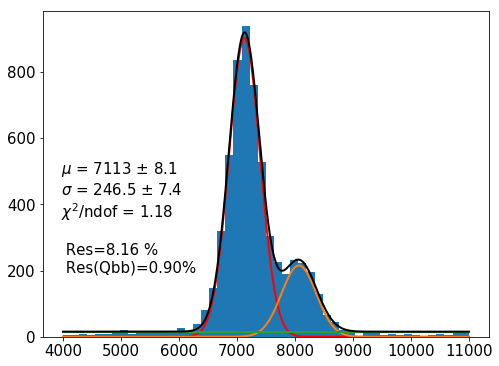

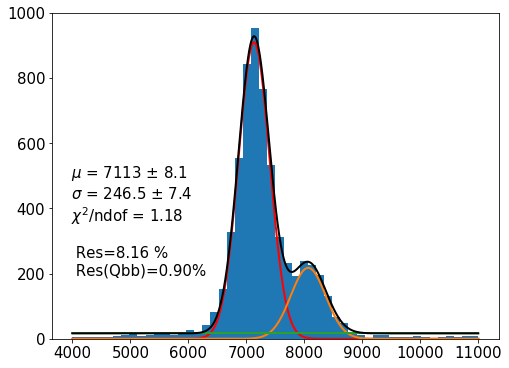

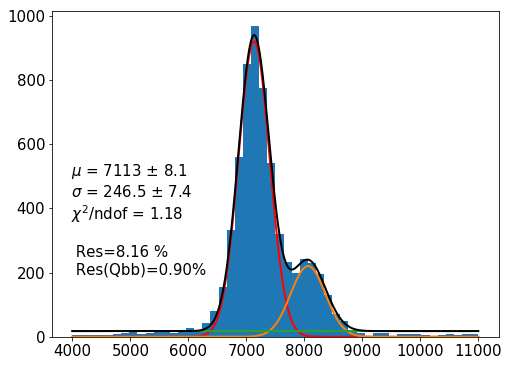

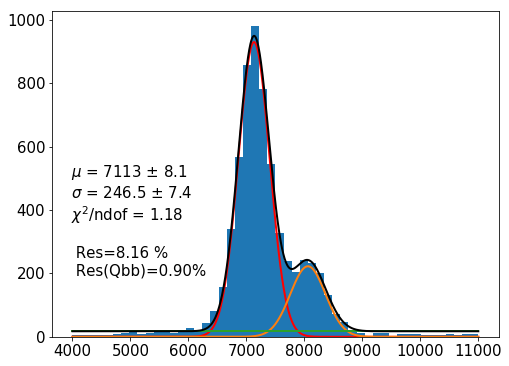

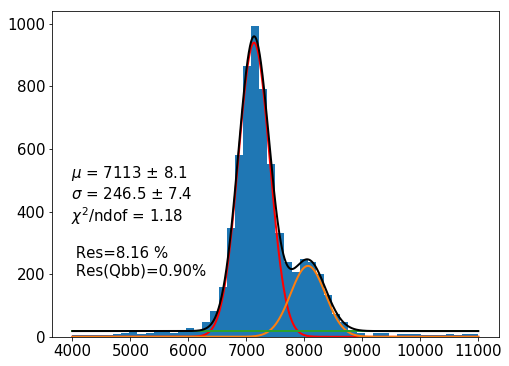

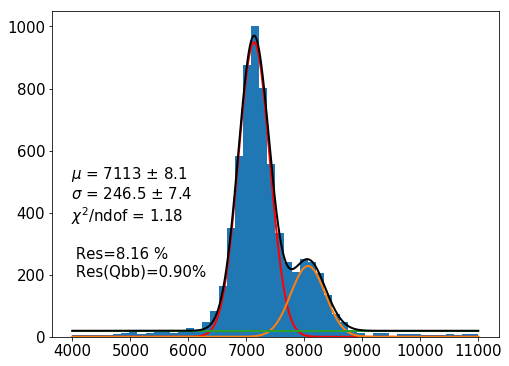

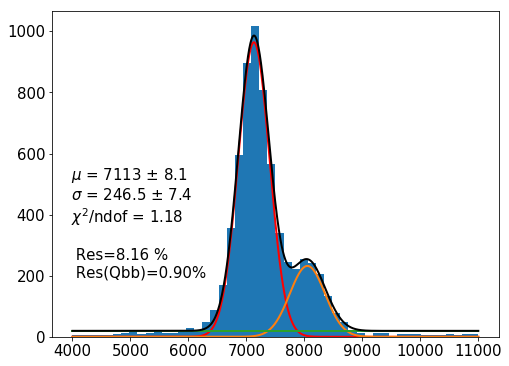

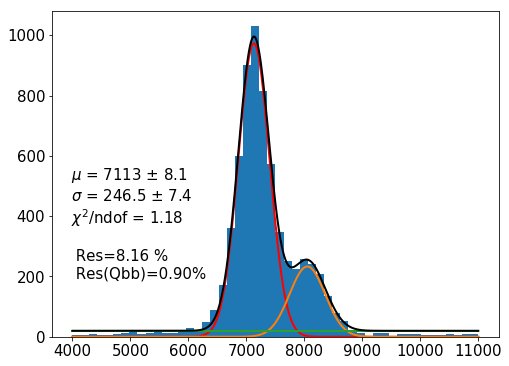

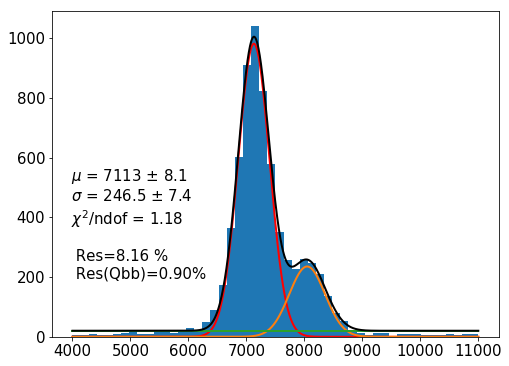

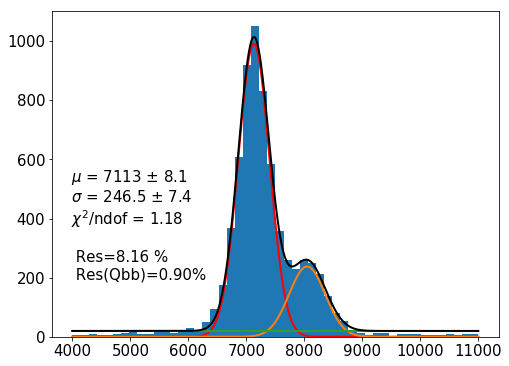

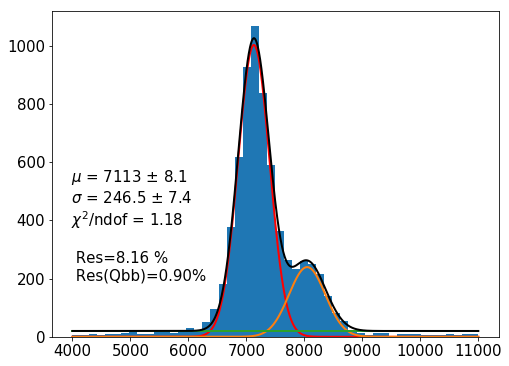

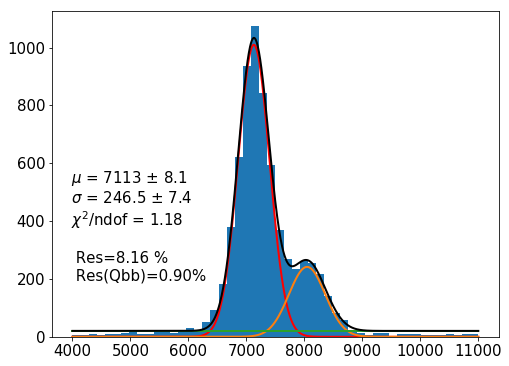

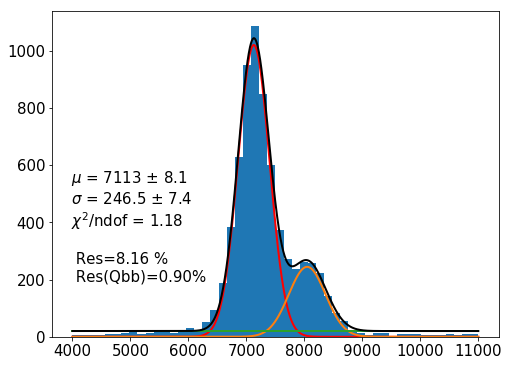

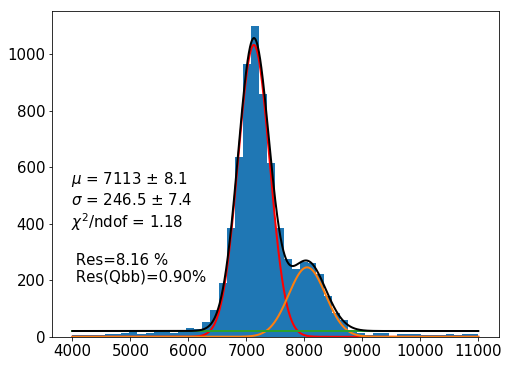

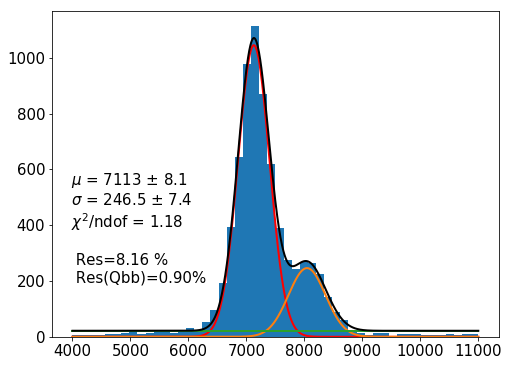

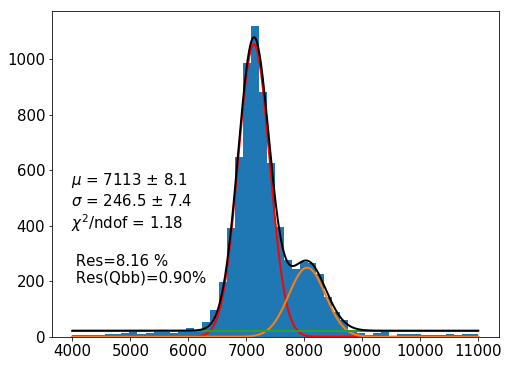

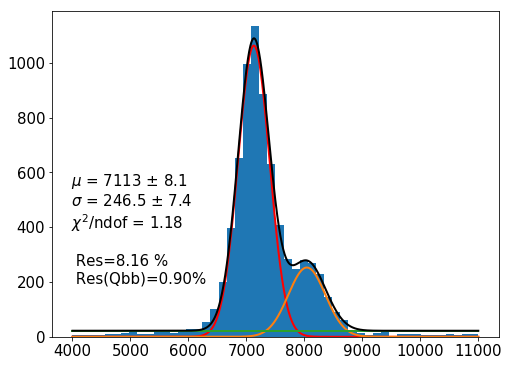

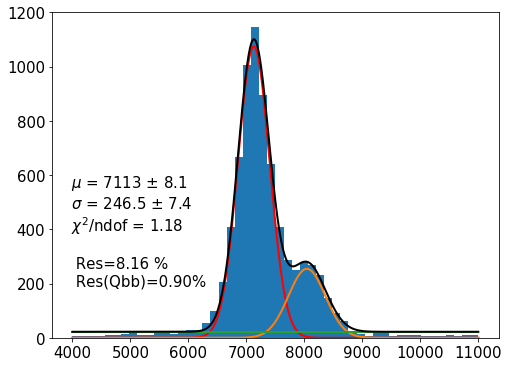

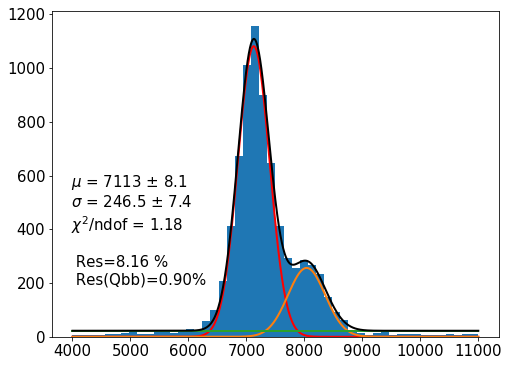

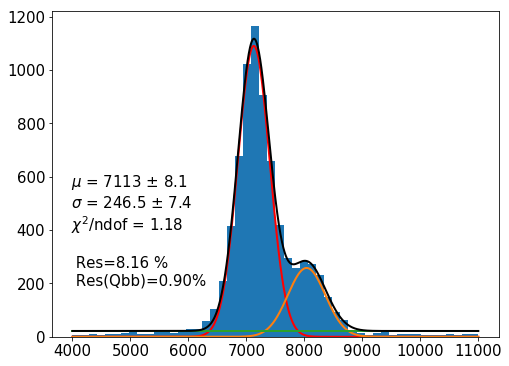

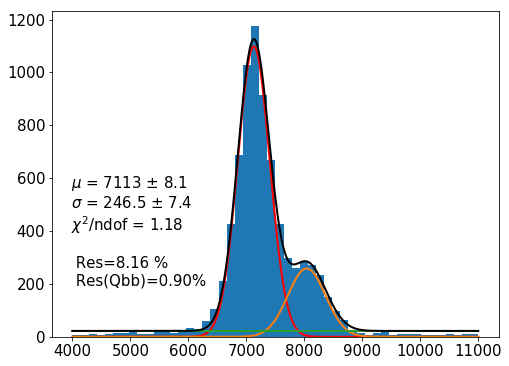

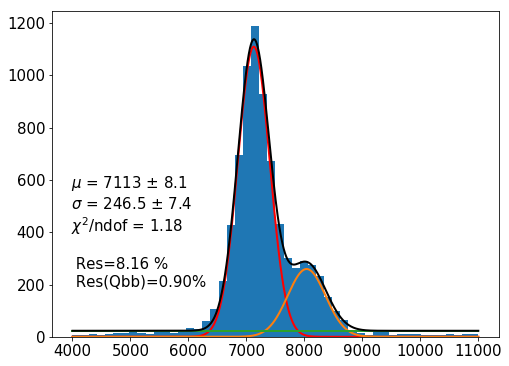

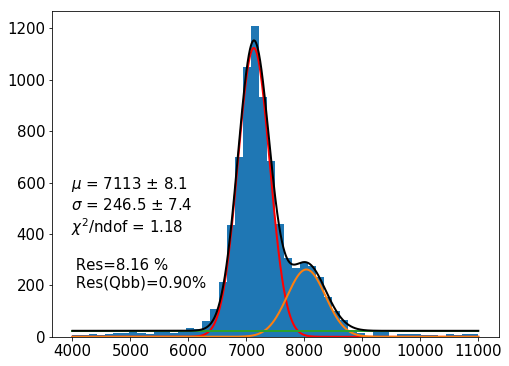

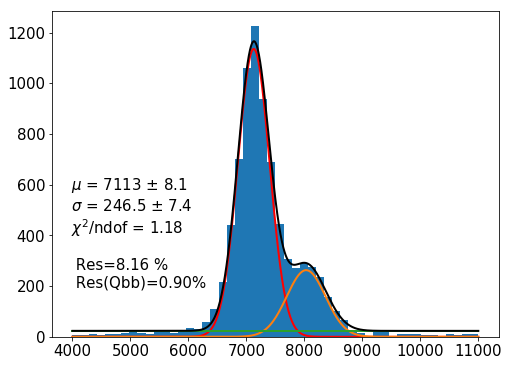

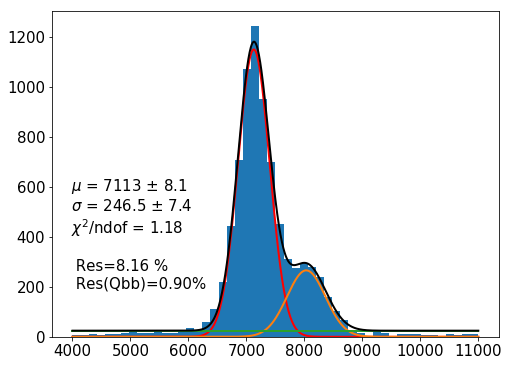

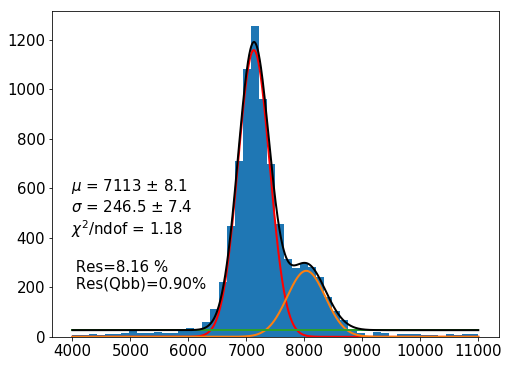

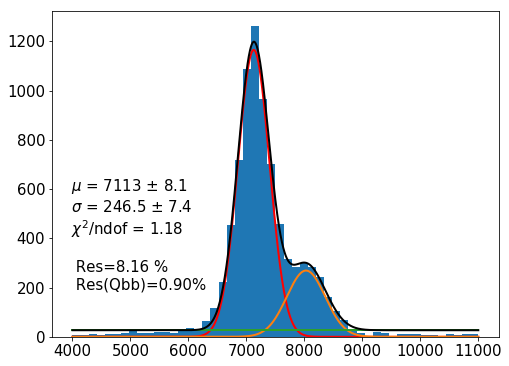

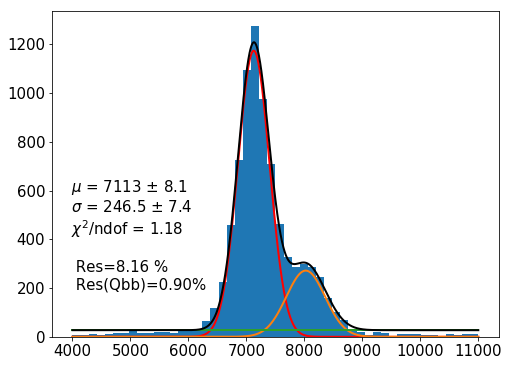

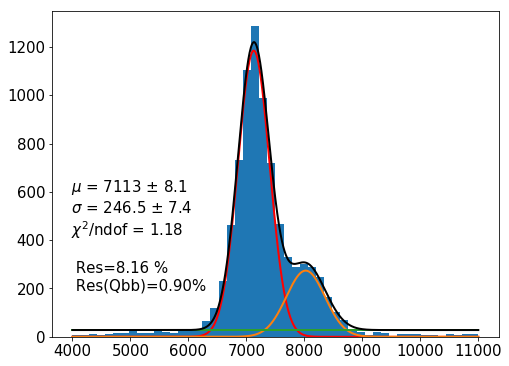

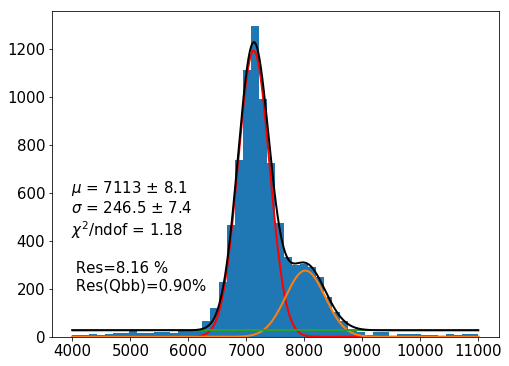

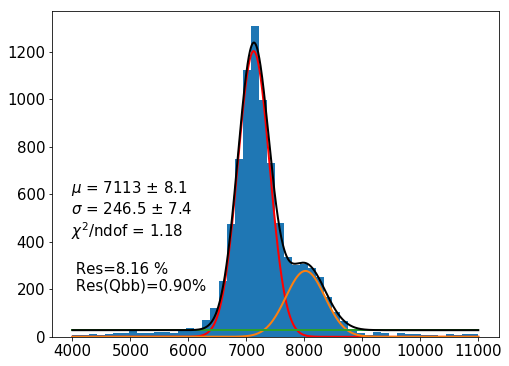

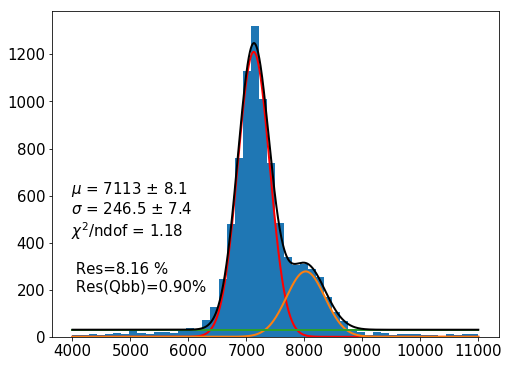

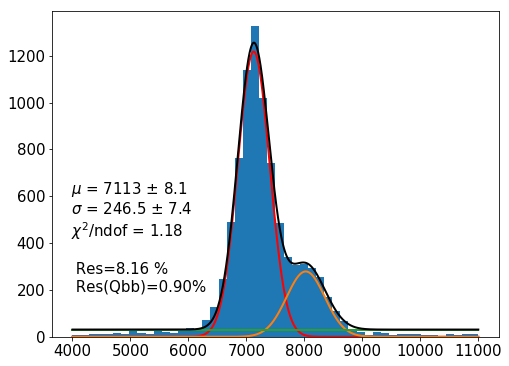

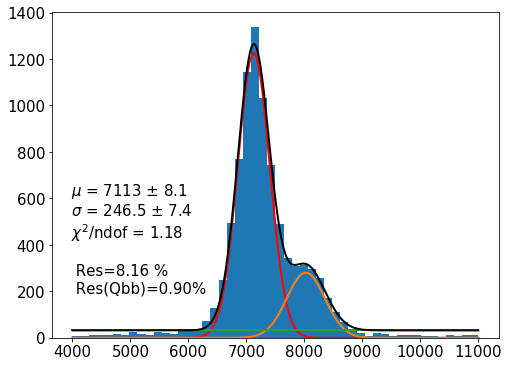

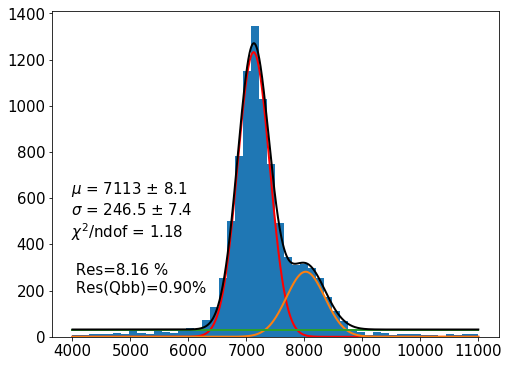

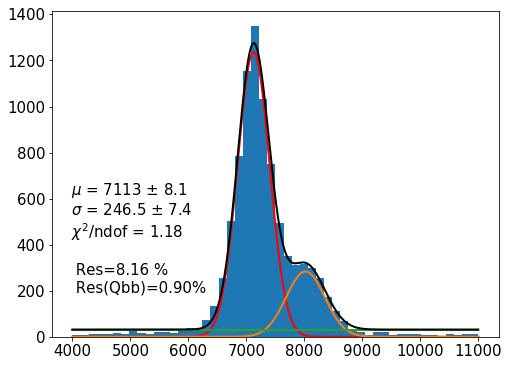

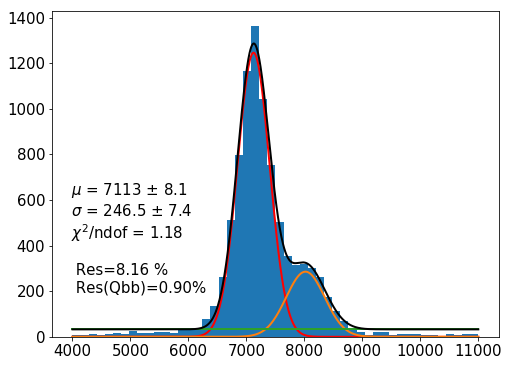

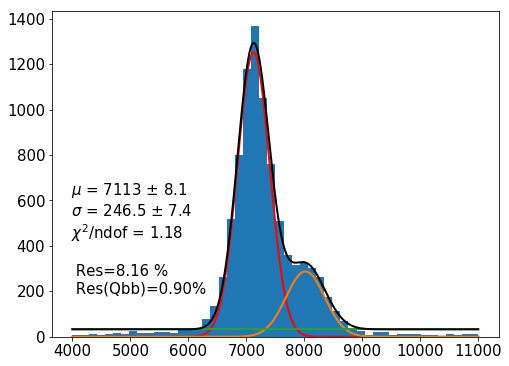

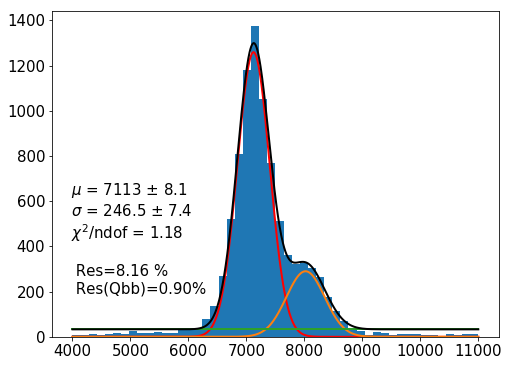

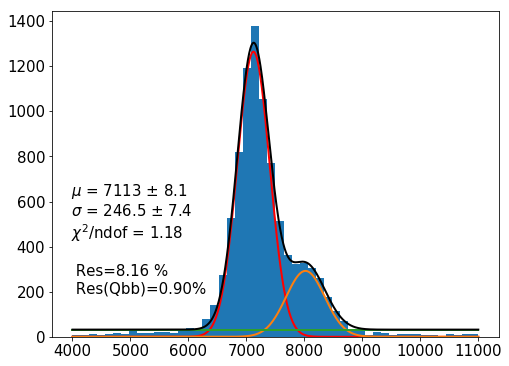

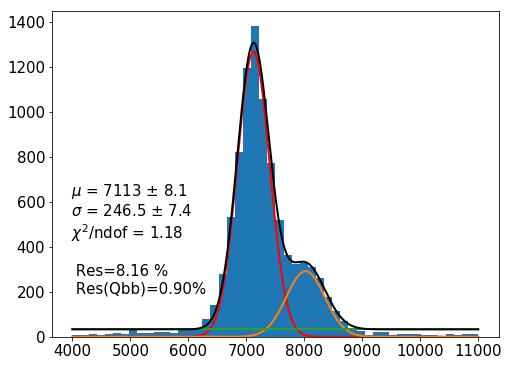

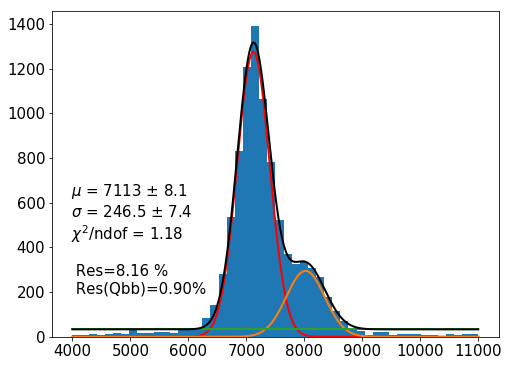

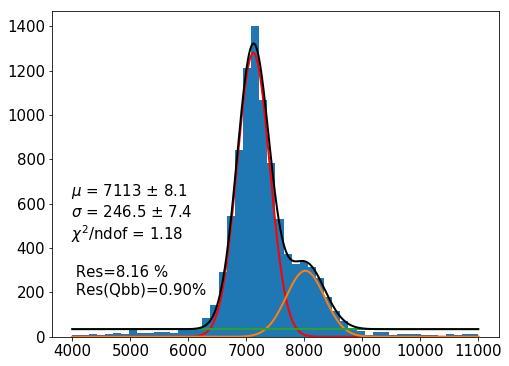

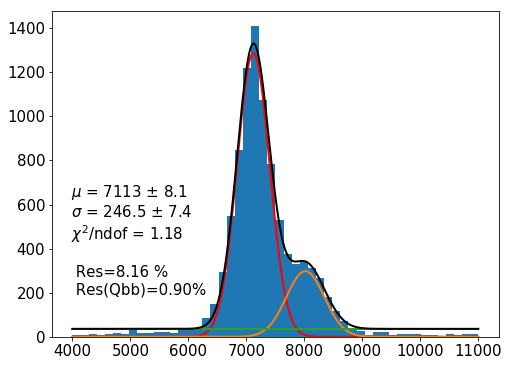

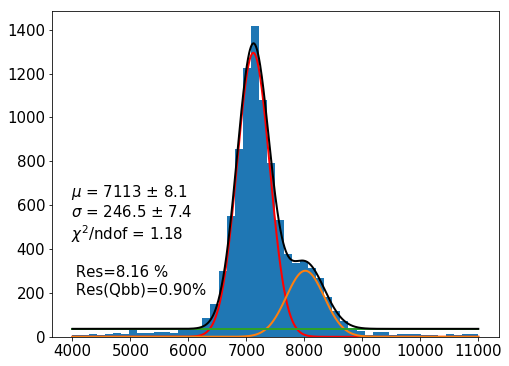

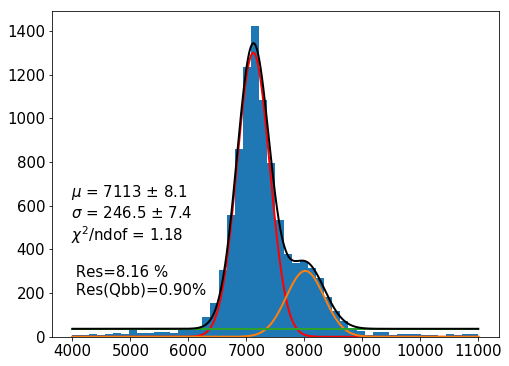

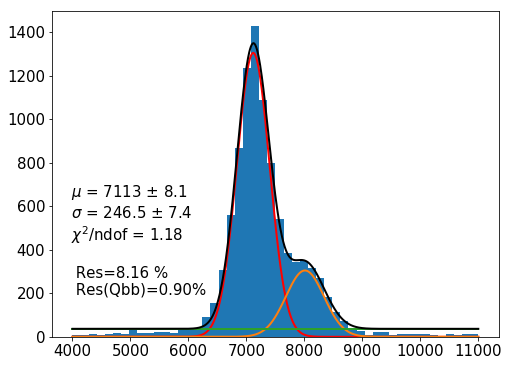

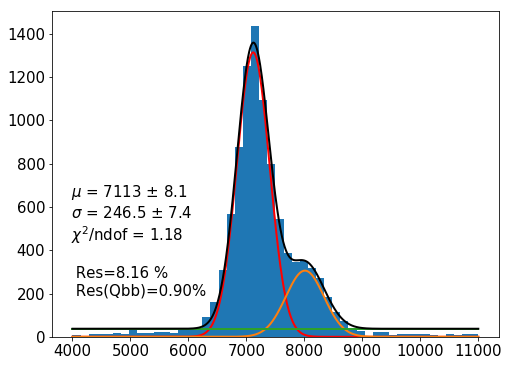

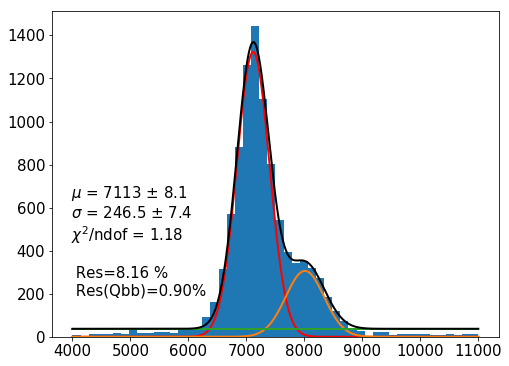

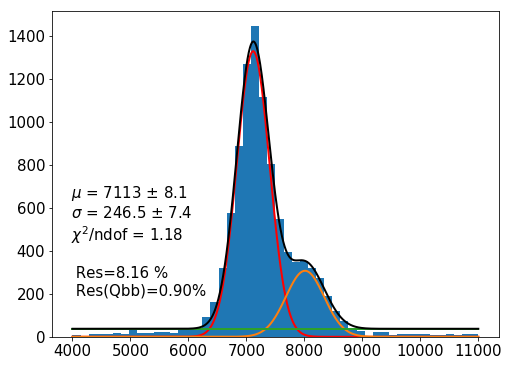

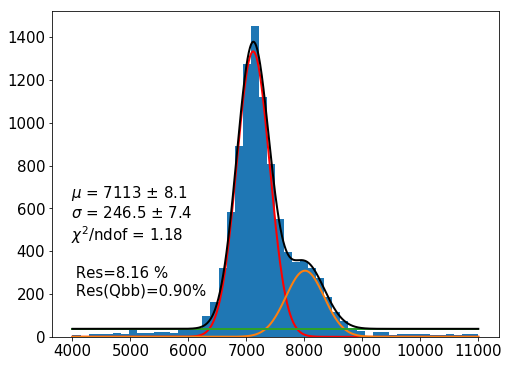

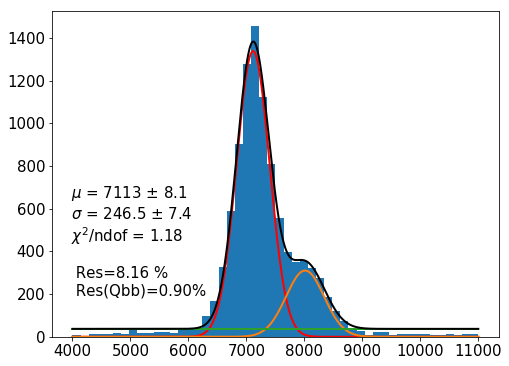

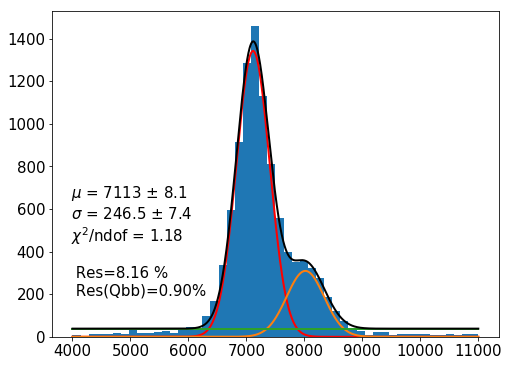

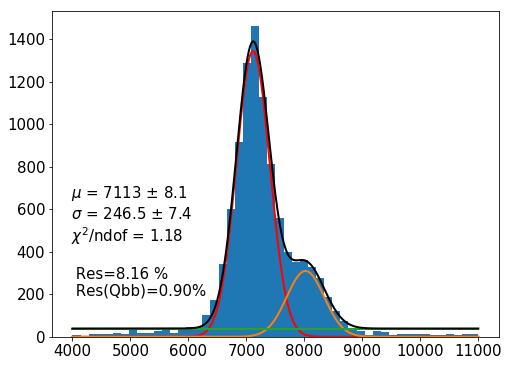

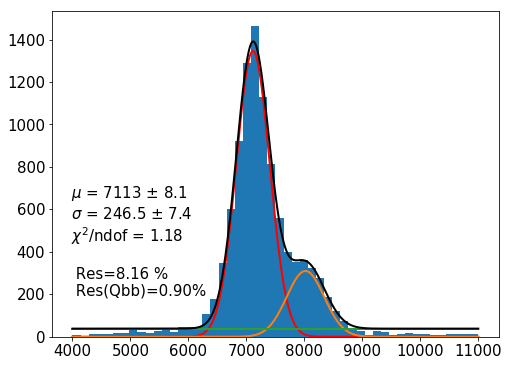

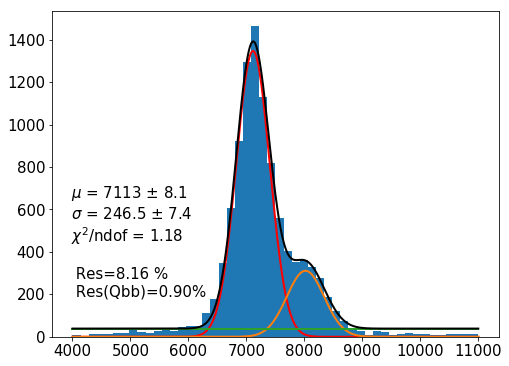

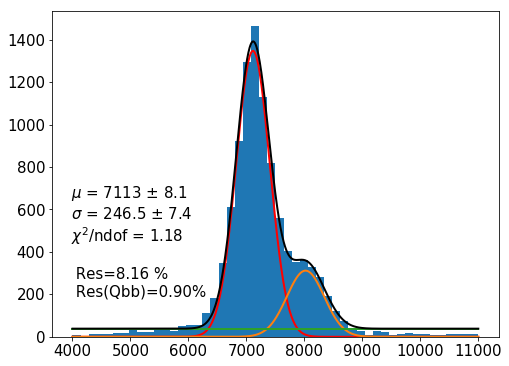

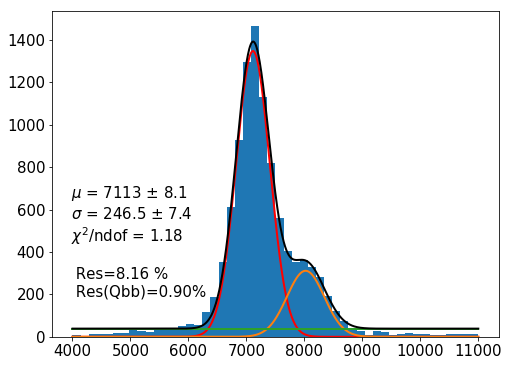

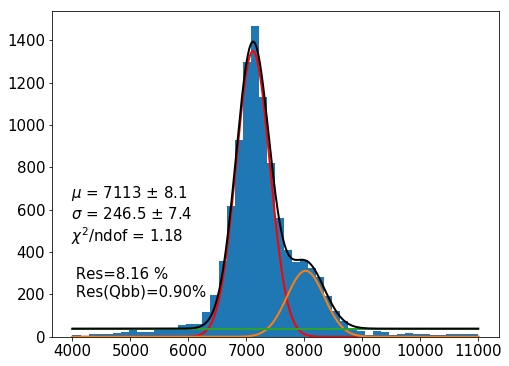

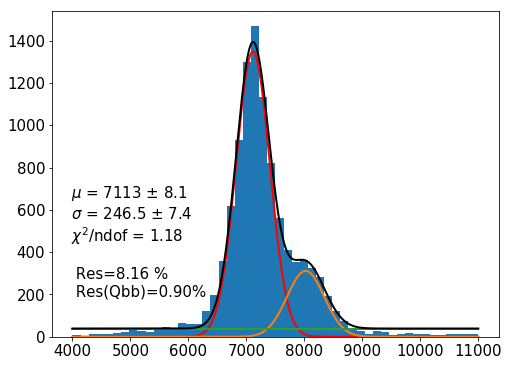

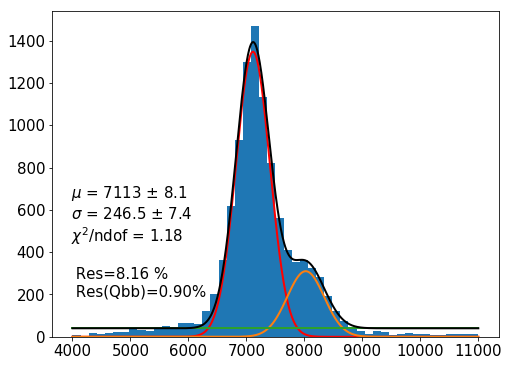

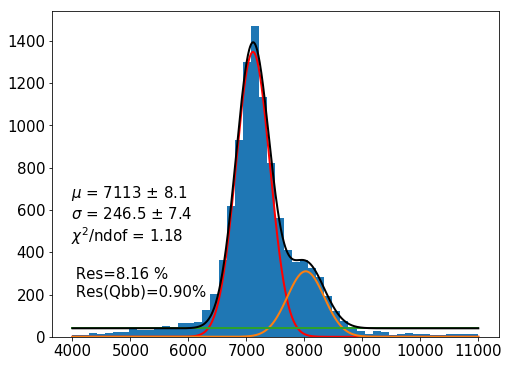

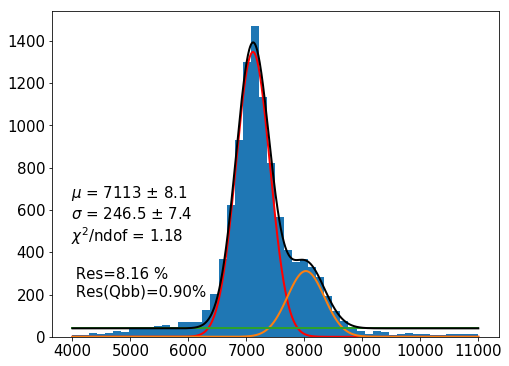

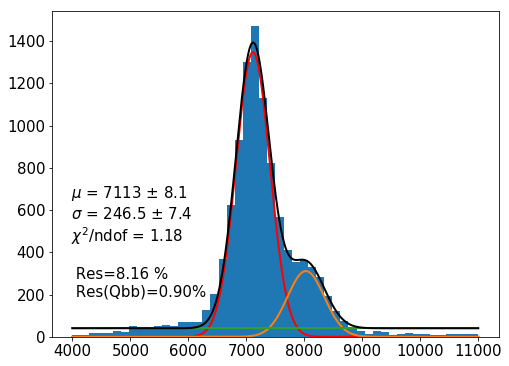

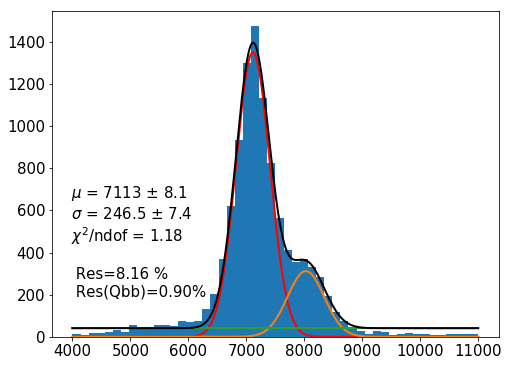

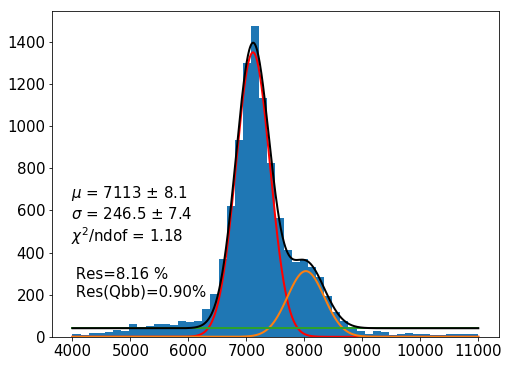

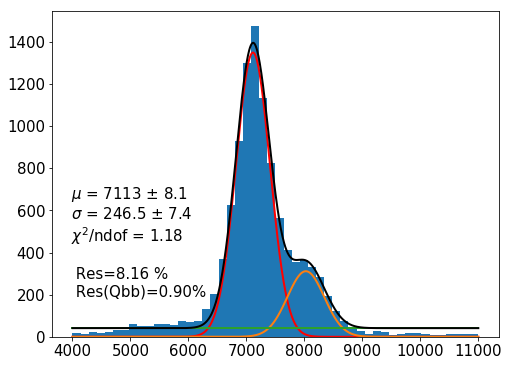

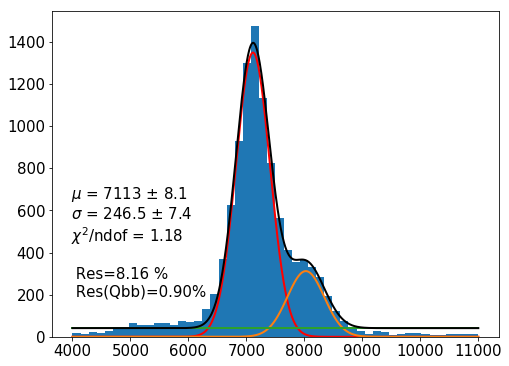

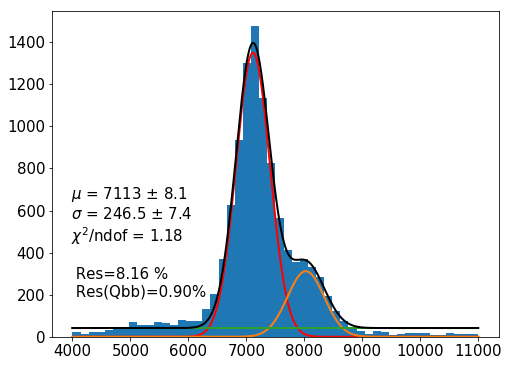

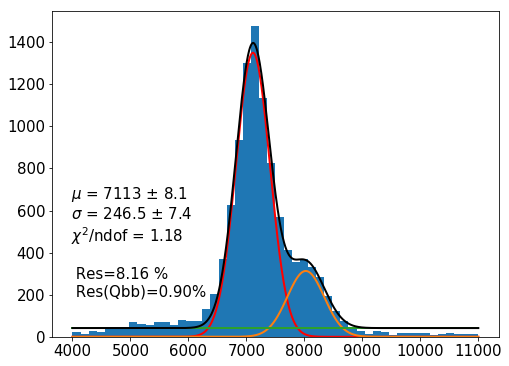

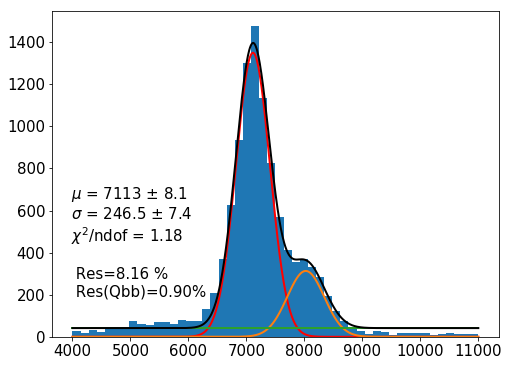

In [65]:
R_list = np.linspace(50,200,150)
res_list = []
for Rcut in R_list:

    data = filt_XR[(filt_XR.Z<150)&(filt_XR.R<Rcut)][:]

    Ez_  = data.S2e * zcorr(data.Z) * xycorr(data.X.values, data.Y.values)

    entries, xbins, _ = hist(Ez_, 50, range=(4e3, 11e3))
    xbins    = get_centers(xbins)
    selbins  = fitf.in_range(xbins, 6.5e3, 9e3)


    f = fitf.fit(fun, xbins[selbins], entries[selbins],( 10e4, 7000, 500, 9e4, 8050, 250, 0),
                                                bounds=([8e4, 6000, 100, 1e4, 7000, 100, 0],
                                                        [10e6, 8000, 1000,15e5, 10000, 500, 100] ))
    mean, sigma = f.values[1], f.values[2]
    res = 2.355*sigma/mean*(29.6/2458)**0.5*100
    res_list.append(res)
    
    xrange = np.linspace(4e3, 11e3,1000)

    plt.text(min(xbins)-100, 200, text, fontsize=15);
    plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
    plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=2)
    plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
    plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)

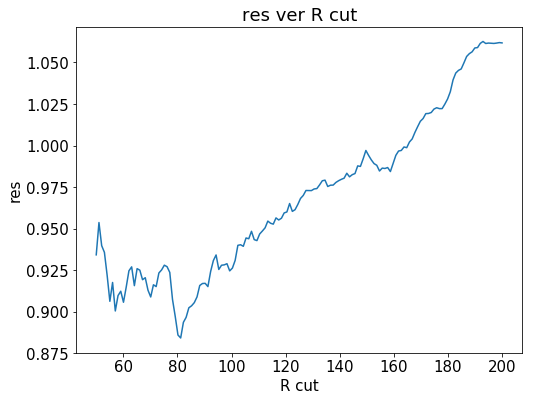

In [68]:
plt.plot(R_list,res_list)
labels("R cut","res")
save("res ver R cut")

In [ ]:
data = filt_XR[(filt_XR.Z>175)&(filt_XR.R<180)][:]
hist2d(data.X, data.Y, [50, 50])
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY_corXYZ")

# Time correction

[  7.15659055e+03   1.27647259e-03]


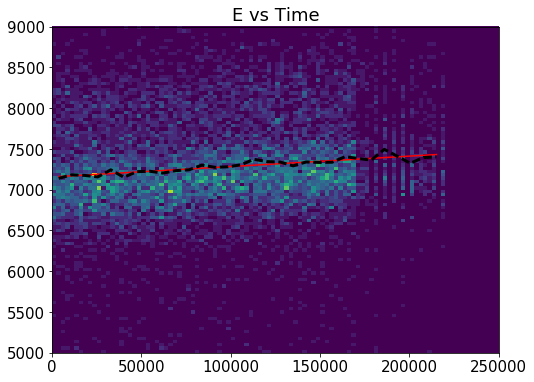

In [69]:
data =filt_XR[(filt_XR.Z<150)&(filt_XR.R<180)]

Et = data.S2e * zcorr(data.Z) * xycorr(data.X.values, data.Y.values)

time = data.time
time = time-np.min(time)
hist2d(time,Et,[100,100], range=[[0,25e4],[5000,9000]]);
x, y, _ = fitf.profileX(time,Et, 30, yrange=[5000,9000])

f = fitf.fit(fitf.polynom, x, y, (6000,-200))
plt.plot(x, f.fn(x), fitOpt)
print(f.values)

plt.plot(x, y, profOpt, linewidth=3)

tfun  = f.fn
tmin  = np.min(x)
tcorr = lambda t: tfun(tmin)/tfun(t)

save("E vs Time")


In [ ]:
150000*10e-4/7000.


In [ ]:
data =filt_XR[(filt_XR.Z<150)&(filt_XR.R<180)]

time = data.time
time = time-np.min(time)

Et = data.S2e * zcorr(data.Z) * xycorr(data.X.values, data.Y.values) * tcorr(time)

hist2d(time, Et,[100,100], range=[[0,25e4],[5000,9000]]);
x, y, _ = fitf.profileX(time, Et, 30, yrange=[5000,9000])
plt.plot(x, y, profOpt, linewidth=3)

In [ ]:
data = filt_XR[(filt_XR.Z<150)&(filt_XR.R<180)][:]

Ez_  = data.S2e * zcorr(data.Z) * xycorr(data.X.values, data.Y.values) * tcorr(data.time-np.min(data.time))

entries, xbins, _ = hist(Ez_, 100, range=(4e3, 11e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 6.5e3, 9e3)


f = fitf.fit(fun, xbins[selbins], entries[selbins],( 10e4, 7000, 500, 9e4, 8050, 500, 0),
                                            bounds=([8e4, 6000, 100, 1e4, 7000, 100, 0],
                                                    [10e6, 8000, 1000,15e5, 10000, 2000, 100] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values,"\n",f.errors)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("$\mu$ $\sigma$".split(),
                                            f.values[1:],
                                            f.errors[1:])] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (29.6/2458)**0.5*res*100)

xrange = np.linspace(4e3, 11e3,1000)

plt.text(min(xbins)-100, 400, text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=2)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)


labels("S2 integral (pes)", "Entries")
save("RX XYZt Corr (Z<150 R<180)")

# Full range results

In [70]:
full = data_read[:]

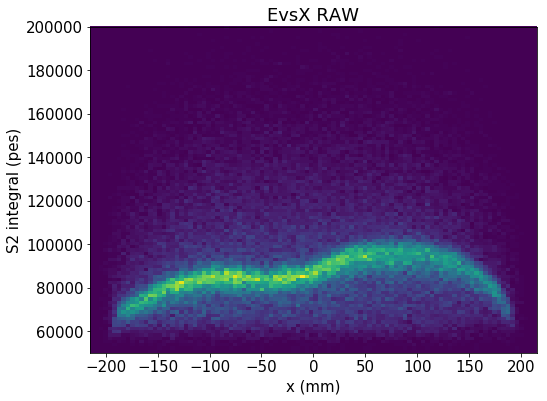

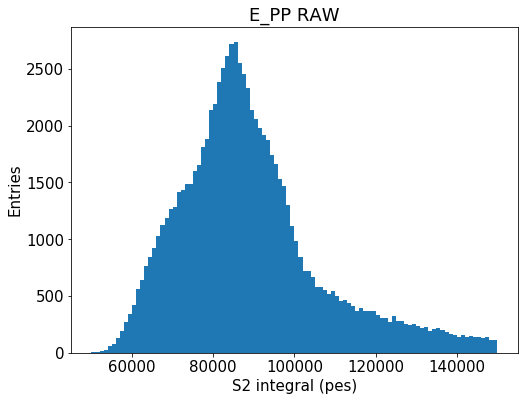

In [77]:
data = full[(full.S1e>100)& (full.S1e<150)&(full.nS2==1)]

hist2d(data.X, data.S2e,[100,100],[[-215,215],[50e3,150e5]]);
labels("x (mm)", "S2 integral (pes)")
save("EvsX RAW")
hist(data.S2e, 100, [50e3, 150e3]);
labels("S2 integral (pes)", "Entries")
save("E_PP RAW")

In [ ]:
data = full[(full.S1e>100)& (full.S1e<150)&(full.nS2==1)]

E =  data.S2e * zcorr(data.Z)# * xycorr(data.X.values, data.Y.values)#*xycorr_PP(data.X.values, data.Y.values)

hist2d(data.X,E,[100,100],[[-215,215],[50e3,150e3]]);
hist(E, 100, [50e3,150e3]);

In [ ]:
data = full[(full.S1e>100)& (full.S1e<150)&(full.nS2==1)&(full.R<180)]

E2 =  data.S2e * zcorr(data.Z) * xycorr(data.X.values, data.Y.values)#*xycorr_PP(data.X.values, data.Y.values)

hist2d(data.X,E2,[100,100],[[-215,215],[50e3,150e3]]);
labels("x (mm)", "S2 integral (pes)")
save("EvsX XYZ corr")
hist(E2, 100, [50e3,150e3]);
labels("S2 integral (pes)", "Entries")
save("E_PP XYZ corr")

In [ ]:
data = full[(full.S1e>100)& (full.S1e<150)&(full.nS2==1)]

E3 =  data.S2e * zcorr(data.Z) * xycorr(data.X.values, data.Y.values)*xycorr_PP(data.X.values, data.Y.values)

hist2d(data.X,E3,[100,100],[[-215,215],[50e3,500e3]]);
hist(E3, 100, [50e3,150e3]);

In [ ]:
data = full[(full.S1e>100)& (full.S1e<150)&(full.nS2==1)]

E1 =  data.S2e * zcorr(data.Z) * xycorr(data.X.values, data.Y.values)
E2 = E1 * xycorr_PP(data.X.values, data.Y.values)

hist(E1,100);
hist(E2,100,[0.05e7,0.4e7]);

In [ ]:
data=full[(full.S1e>100)&(full.S1e<150)&(full.X>-100)&(full.X<-10)&(full.nS2==1)&(full.Z>150)&(full.Z<200)]

E = data.S2e * zcorr( data.Z)

_ = hist2d(data.Z, E, [100,100], range=([[150,200],[0.5e5,2e5]]))

entries, xbins, _ = hist(E, 100, range=(0.5e5,2e5))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 1.1e5, 1.3e5)

func = lambda x, *args: fitf.gauss(x, *args[:3])# + args[-1] 
f = fitf.fit(func, xbins[selbins], entries[selbins],(10e4, 0.9e6, 1e6))#, 20))#,
                                            #ounds=([8e4, 6000, 100, 1e4, 7000, 100, 0],
                                            #        [10e6, 8000, 1000,15e5, 10000, 2000, 100] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values,"\n",f.errors)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("$\mu$ $\sigma$".split(),
                                            f.values[1:],
                                            f.errors[1:])] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)

xrange = np.linspace(xbins[0],xbins[-1],1000)

#plt.text(min(xbins)-100, 400, text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=3)
#plt.plot(xrange, fitf.expo(xrange, *f.values[3:-1]), linewidth=3)
#plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=3)
#plt.plot(xrange, f.fn(xrange), "k-", linewidth=3)


hist2d(E,data.Y,100, [[0.5e5,2e5],[-50,50]]);

In [ ]:
data=full[(full.S1e>100)&(full.S1e<150)&(full.X>-100)&(full.X<-10)&(full.nS2==1)&(full.Z>150)&(full.Z<200)]

E = data.S2e * zcorr( data.Z)

hist2d(data.Y, E, 100, [[-50,50],[0.8e5,1.6e5]]);

x, y, _ = fitf.profileX(data.Y, E, 100, xrange = ([-15,15]), yrange = ([1.08e5,1.6e5]))
plt.plot(x, y, profOpt)
fun = lambda x, *args: fitf.expo(x,*args[:2])/fitf.power(x, *args[2:])
f = fitf.fit(fitf.polynom, x, y, (40,140e3))
plt.plot(x, f.fn(x), fitOpt)

yfun  = f.fn
ymin  = np.min(x)
ycorr = lambda t: yfun(ymin)/yfun(t)


In [ ]:
data = full[(full.S1e>100)&(full.S1e<150)&(full.X>-100)&(full.X<-10)&(full.nS2==1)&(full.Z>150)&(full.Z<200)]

E = data.S2e * zcorr( data.Z) * xycorr( data.X.values,data.Y.values)

entries, xbins, _ = hist(E, 100, range=(0.8e5,1.6e5))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 1.2e5,1.35e5)

func = lambda x, *args: fitf.gauss(x, *args[:3])# + args[-1] 
f = fitf.fit(func, xbins[selbins], entries[selbins],(10e4, 0.9e6, 1e6))#, 20))#,
                                            #ounds=([8e4, 6000, 100, 1e4, 7000, 100, 0],
                                            #        [10e6, 8000, 1000,15e5, 10000, 2000, 100] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values,"\n",f.errors)
print('res',res,(511/2458)**0.5*res)
'''
text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("$\mu$ $\sigma$".split(),
                                            f.values[1:],
                                            f.errors[1:])] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)
'''
xrange = np.linspace(xbins[0],xbins[-1],1000)

#plt.text(min(xbins)-100, 400, text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=3)
#plt.plot(xrange, fitf.expo(xrange, *f.values[3:-1]), linewidth=3)
#plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=3)
#plt.plot(xrange, f.fn(xrange), "k-", linewidth=3)35

In [ ]:
r_fullE = fullE[(full.S1e>100)& (full.S1e<150)] * rcorr(full.R[(full.S1e>100)& (full.S1e<150)])

entries, xbins, _ = hist(r_fullE, 100, range=(0,4e5))

entries, xbins, _ = hist(r_fullE, 100, range=(7e4,1.5e5))
a = pdf(r_fullE, 100, range=(0,4e5))

In [ ]:
r_fullE = fullE * rcorr(full.R)

entries, xbins, _ = hist(full[(full.S1e>100)& (full.S1e<150)].S2e, 100, range=(0,2e5))

entries, xbins, _ = hist(full[(full.S1e>100)& (full.S1e<150)].S2e, 100, range=(5e4,1.5e5))
a = pdf(full[(full.S1e>100)& (full.S1e<150)].S2e, 100, range=(0,2e5))

In [ ]:
r_fullE_c = full[(full.R<100)&(full.S1e>100)& (full.S1e<150)&(full.Z<100)].S2e

entries, xbins, _ = hist(r_fullE_c, 100, range=(0,2e5))

entries, xbins, _ = hist(r_fullE_c, 100, range=(5e4,1.5e5))
a = pdf(r_fullE_c, 100, range=(0,2e5))

In [ ]:
r_fullE_c = r_fullE[(full.R<100)&(full.S1e>100)& (full.S1e<150)&(full.Z<100)]

entries, xbins, _ = hist(r_fullE_c, 100, range=(0,2e5))

entries, xbins, _ = hist(r_fullE_c, 100, range=(5e4,1.5e5))
a = pdf(r_fullE_c, 100, range=(0,2e5))


In [ ]:
a = hist2d(full[(full.S1e>100)& (full.S1e<150)&(full.Z>175)].X, 
                        full[(full.S1e>100)& (full.S1e<150)&(full.Z>175)].Y,                        
                        [40,40], range=([[-200,200],[-200,200]]));

In [ ]:
data = full[(full.S1e>100)& (full.S1e<150)&(full.Z>175)&(full.X<100)&(full.X>50)&(full.nS2==1)]

E =  data.S2e * zcorr(data.Z) * xycorr(data.X.values, data.Y.values)


entries, xbins, _ = hist(E,50,[90e3,150e3]);
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 127e3,145e3)
print(xbins[selbins].size)

func = lambda x, *args: fitf.gauss(x, *args[:3]) + args[-1] 
f = fitf.fit(func, xbins[selbins], entries[selbins],(10e4, 95e3, 100e3, 20))#,
                                            #bounds=([8e4, 6000, 100, 1e4, 7000, 100, 0],
                                            #        [10e6, 8000, 1000,15e5, 10000, 2000, 100] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values,"\n",f.errors)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("$\mu$ $\sigma$".split(),
                                            f.values[1:],
                                            f.errors[1:])] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)

xrange = np.linspace(90e3,150e3,1000)

#plt.text(min(xbins)-100, 400, text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=3)
#plt.plot(xrange, fitf.expo(xrange, *f.values[3:-1]), linewidth=3)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=3)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=3)


In [ ]:
2.19748094e6/(xbins[1]-xbins[0])

In [ ]:
a = hist(full[(full.S1e>100)& (full.S1e<150)&(full.Z>175)].S2e,100);

In [ ]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 250
prange = - pi,  pi
Erange =  50e3, 150e3
nbin = 25

#data = filt_XR[filt_XR.Z<150][:]
data = full[(full.S1e>100)& (full.S1e<150)&(full.Z>175)&(full.nS2==1)]

Ez =  data.S2e * zcorr(data.Z) * xycorr(data.X.values, data.Y.values)


pf, _, cb = profile_and_scatter(data.X, data.Y, Ez, (nbin, nbin), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

_, _, cb = profile_and_scatter(data.R, data.Phi, Ez, (nbin, nbin), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi")

hist2d(data.R, Ez, (nbin, nbin), range=(rrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.R, Ez, nbin, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(data.Phi, Ez, (nbin, nbin), range=(prange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.Phi, Ez, nbin, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")

hist2d(data.X, Ez, (nbin, nbin), range=(xrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.X, Ez, nbin, xrange=xrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("X (mm)", "S2 energy (pes)")

hist2d(data.Y, Ez, (nbin, nbin), range=(yrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.Y, Ez, nbin, xrange=xrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("Y (mm)", "S2 energy (pes)")

print('jijijiji',np.nanmax(Ez.values))
np.savetxt('xycorr_xs_PP_3614.dat',np.array(pf[0]))
np.savetxt('xycorr_ys_PP_3614.dat',np.array(pf[1]))
np.savetxt('xycorr_es_PP_3614.dat',np.array(pf[2]))
xycorr_PP = get_xycorr(*pf[:-1], eref=np.nanmax(Ez.values))

In [ ]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 250
prange = - pi,  pi
Erange =  500e3,3e6


data = full[(full.S1e>100)& (full.S1e<150)&(full.Z>175)&(full.nS2==1)]

Ez  = data.S2e * zcorr(data.Z) * xycorr(data.X.values, data.Y.values) * xycorr_PP(data.X.values, data.Y.values)



hist(Ez,100,Erange);

#filt_XR[filt_XR.Z<150].X[:], filt_XR[filt_XR.Z<150].Y[:]

pf, _, cb = profile_and_scatter(data.X, data.Y, Ez, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY_corXYZ")

_, _, cb = profile_and_scatter(data.R, data.Phi, Ez, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi_corXYZ")

hist2d(data.R, Ez, (50, 50), range=(rrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.R, Ez, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR_corXYZ")

hist2d(data.Phi, Ez, (50, 50), range=(prange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.Phi, Ez, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi_corXYZ")


hist2d(data.X, Ez, (nbin, nbin), range=(xrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.X, Ez, nbin, xrange=xrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("X (mm)", "S2 energy (pes)")

hist2d(data.Y, Ez, (nbin, nbin), range=(yrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.Y, Ez, nbin, xrange=xrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("Y (mm)", "S2 energy (pes)")

hist2d(data.X,Ez,[100,100],range=(xrange,Erange));



In [ ]:
Erange =  1.5e6,2.5e6


data = full[(full.S1e>100)& (full.S1e<150)&(full.Z>175)&(full.nS2==1)]

E  = data.S2e * zcorr(data.Z) * xycorr(data.X.values, data.Y.values) * xycorr_PP(data.X.values, data.Y.values)


entries, xbins, _ = hist(E,50,Erange);
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins,2.1e6,Erange[1])
print(xbins[selbins].size)

func = lambda x, *args: fitf.gauss(x, *args[:3]) + args[-1] 
f = fitf.fit(func, xbins[selbins], entries[selbins],(10e4, 2.0e6, 1e6, 20))#,
                                            #bounds=([8e4, 6000, 100, 1e4, 7000, 100, 0],
                                            #        [10e6, 8000, 1000,15e5, 10000, 2000, 100] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values,"\n",f.errors)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("$\mu$ $\sigma$".split(),
                                            f.values[1:],
                                            f.errors[1:])] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)

xrange = np.linspace(Erange[0],Erange[1],1000)

#plt.text(min(xbins)-100, 400, text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=3)
#plt.plot(xrange, fitf.expo(xrange, *f.values[3:-1]), linewidth=3)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=3)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=3)

In [ ]:
Erange =  1.8e6,2.3e6


data = full[(full.S1e>100)& (full.S1e<150)&(full.Z>150)&(full.Z<200)&(full.nS2==1)&(full.X>-100)&(full.X<-10)& (full.Y<20)& (full.Y>-20)]
time = data.time
time = time-np.min(time)
E  = data.S2e *zcorr(data.Z) *xycorr(data.X.values, data.Y.values) *xycorr_PP(data.X.values, data.Y.values) #*tcorr(time)


entries, xbins, _ = hist(E,50,Erange);
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins,1.975e6,2.3e6)
print(xbins[selbins].size)

func = lambda x, *args: fitf.gauss(x, *args[:3]) + args[-1] 
f = fitf.fit(fun, xbins[selbins], entries[selbins],( 10e4, 2.2e6, 10e6, 1e4 , 1.9e6, 10e6, 1),
                                            bounds=([8e4 , 1.9e6, 1e1, 1e4 , 1.7e6, 100, 0],
                                                    [100e6, 2.3e6, 20e6, 150e5, 2.05e6, 50e6, 23] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values,"\n",f.errors)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("$\mu$ $\sigma$".split(),
                                            f.values[1:],
                                            f.errors[1:])] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)

xrange = np.linspace(Erange[0],Erange[1],1000)

#plt.text(min(xbins)-100, 400, text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=3)
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=3)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=3)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=3)

In [ ]:
data = full[(full.S1e>100)& (full.S1e<150)&(full.Z>175)&(full.Z<200)&(full.nS2==1)&(full.X>-100)&(full.X<-10)& (full.Y<20)& (full.Y>-20)]
time = data.time
time = time-np.min(time)
E  = data.S2e *zcorr(data.Z) *xycorr(data.X.values, data.Y.values) *xycorr_PP(data.X.values, data.Y.values) *tcorr(time)

hist2d(data.Z,E,[100,100]);

In [ ]:
data = full[(full.S1e>100)& (full.S1e<150)&(full.Z>175)&(full.Z<200)&(full.nS2==1)&(full.X>-100)&(full.X<-10)]
hist2d(data.X, data.S2e,[100,100],[[-100,-10],[0.6e5,1e5]]);

In [ ]:
xs = np.loadtxt('xycorr_xs_PP_3740.dat')
ys = np.loadtxt('xycorr_ys_PP_3740.dat')
es = np.loadtxt('xycorr_es_PP_3740.dat')

xycorr_PP_3740 = get_xycorr(xs, ys,es)

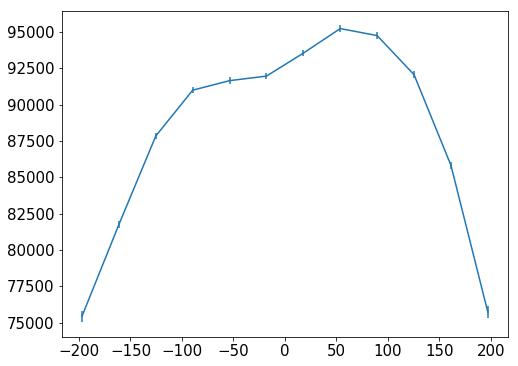

In [36]:
data_ = full[(full.S1e>100)& (full.S1e<150)&(full.nS2==1)&(full.R<200)]
E = data_.S2e 

x, y, ey = fitf.profileX(data_.X,E,12,xrange=(-215,215),yrange=(50e3,2e5))
plt.errorbar(x,y,ey)
plt.show()

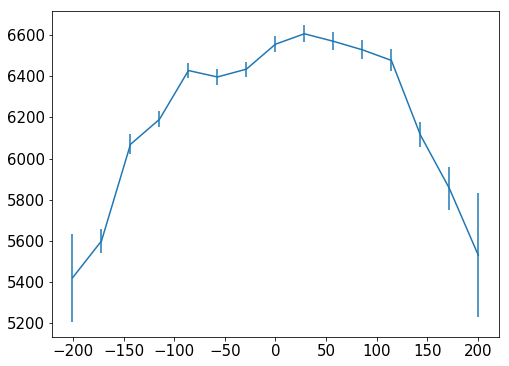

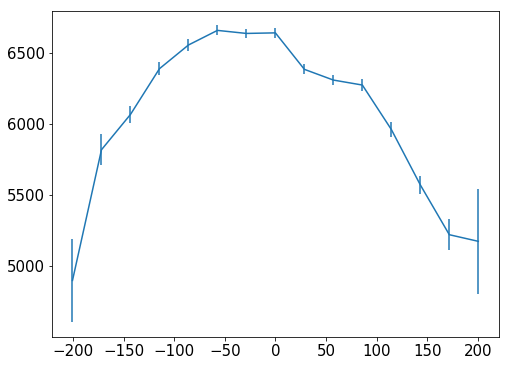

In [38]:
data_ = filt_XR
data_ = filt_XR[(data_.R<200)& (data_.Z<150)]
E = data_.S2e 

x, y, ey = fitf.profileX(data_.X,E,15,xrange=(-215,215),yrange=(1.0e3, 12e3))
plt.errorbar(x,y,ey)
plt.show()

x, y, ey = fitf.profileX(data_.Y,E,15,xrange=(-215,215),yrange=(1.0e3, 12e3))
plt.errorbar(x,y,ey)
plt.show()

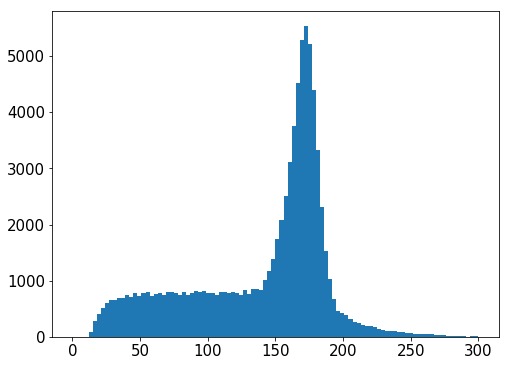

In [85]:
data_ = full[(full.S1e>100)& (full.S1e<150)&(full.nS2==1)&(full.R<200)]
E = data_.S2e 

hist(data_.Z,100,[0,300])
data = full[(full.S1e>100)& (full.S1e<150)&(full.Z>175)&(full.Z<200)&(full.nS2==1)plt.show()

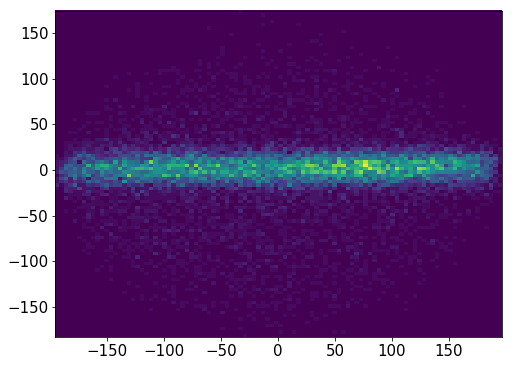

In [34]:
data = full[(full.S1e>100)& (full.S1e<150)&(full.Z>175)&(full.Z<200)&(full.nS2==1)]
#profile_and_scatter(data.X,data.Y,data.S2e,[100,100], xrange=(-215,215),yrange=(-215,215));
hist2d(data.X,data.Y,[100,100]);
